# Setup

In [1]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/AI-ML-Stuff/Dissertation/work/Transformer-Masking
  %pip install transformer_lens
  %pip install scikit-learn
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Colab notebook
Mounted at /content/gdrive
/content/gdrive/MyDrive/AI-ML-Stuff/Dissertation/work/Transformer-Masking
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.4 MB

In [2]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook_connected" # or use "browser" if you want plots to open with browser
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum
from typing import List, Optional, Callable, Tuple, Union
import functools
from tqdm import tqdm
from IPython.display import display
import random
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import json


from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

In [3]:
# Run a dataset through the model, store all the activations
def dataset_activations(
  model: HookedTransformer,
  dataset: List[str],
  batch_size: int = None
):
  # TODO: make this run in batches instead of at once.
  # if batch_size != None:

  # Tokenise the batch, form a batch tensor
  batch_tokens = model.to_tokens(dataset)
  # Feed the tensor through the model
  logits, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)

  return logits, cache

In [4]:
def activation_plot_multiple_datasets(
  model: HookedTransformer,
  datasets_lang: List[str],
  datasets_tokens: List,
  plot_type: str,
  location: str,
  dimension: int,
  random: bool = False,
  centre: bool = True
):
  """
  Given a dataset, create a plot of the activations for the final token.
  Use gpt 2 small, look at any given location.
  Works for either numerical or categorical labels.
  Should support both t-SNE and PCA.
  """
  t.cuda.empty_cache()
  activation_dict = {}
  # Do the forward pass for each dataset
  for name in datasets_lang:
    dataset_lang = datasets_lang[name]
    activations = dataset_activations(model, dataset_lang)[1][location]
    # Looking at the final activations! Might want to change this?
    final_activations = activations[:,-1,:]

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  for name in datasets_tokens:
    dataset_token = datasets_tokens[name]
    activations = dataset_activations_tokens(model, dataset_token)[1][location]
    # Looking at the final activations! Might want to change this?
    final_activations = activations[:,-1,:]

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  all_data = []
  all_labels = []
  for label, data in activation_dict.items():
      all_data.append(data)
      all_labels.extend([label] * len(data))

  all_data = np.concatenate(all_data, axis=0)

  if random:

    # Determine the number of data points per label (assuming all labels have the same number of data points)
    num_points_per_label = len(activation_dict[list(activation_dict.keys())[0]])

    # Calculate the mean and variance of the entire dataset
    mean = np.mean(all_data, axis=0)
    variance = np.var(all_data, axis=0)
    # Generate some random data
    # Will use the same mean and variance as the data
    # Generate synthetic data with the same variance
    if centre:
      synthetic_data = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    else:
      zeros = 0 * mean
      synthetic_data = np.random.normal(loc=zeros, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    synthetic_labels = ['Synthetic'] * len(synthetic_data)

    # Concatenate the synthetic data with the original data
    all_data = np.concatenate([all_data, synthetic_data], axis=0)
    all_labels.extend(synthetic_labels)



  # Initialize the t-SNE
  tsne = TSNE(n_components=2, random_state=21)

  # Fit and transform the data to 2D
  data_2d = tsne.fit_transform(all_data)

  # Shuffle the data and labels
  data_2d, all_labels = shuffle(data_2d, all_labels, random_state=42)

  # Plot the transformed data
  # Create a colormap for labels
  unique_labels = list(set(all_labels))
  colors = plt.cm.get_cmap('viridis', len(unique_labels))

  # Plot the transformed data with labels
  plt.figure(figsize=(6, 5))
  markers = ['o', 's', '^', 'D', 'P']

  # Plot all points together, coloring them based on their labels
  for i, label in enumerate(all_labels):
      color_idx = unique_labels.index(label)
      marker = markers[color_idx % len(markers)]
      plt.scatter(data_2d[i, 0], data_2d[i, 1], color=colors(color_idx), s=20, alpha=0.6, label=label if color_idx not in [unique_labels.index(lbl) for lbl in all_labels[:i]] else "", marker=marker)

  # Add a legend
  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend(handles, labels, title="Labels")

  plt.xlabel('t-SNE feature 0')
  plt.ylabel('t-SNE feature 1')
  plt.title(f't-SNE visualization of the final activations of {model.name} at {location}')
  plt.show()

In [5]:
from torch.nn.utils.rnn import pad_sequence

def dataset_activations_optimised(
  model: HookedTransformer,
  dataset: List[str],
  location: str,
  max_batch_size: int
):

  num_batches = (len(dataset) + max_batch_size - 1) // max_batch_size
  all_final_activations = []

  # Process each batch
  for batch_idx in range(num_batches):
    t.cuda.empty_cache()
    # print("batch_idx be: ", batch_idx)
    # Determine the start and end index for this batch
    start_idx = batch_idx * max_batch_size
    end_idx = min(start_idx + max_batch_size, len(dataset))

    # Extract the subset of the dataset for this batch
    batch_subset = dataset[start_idx:end_idx]

    # print(batch_subset)

    # print(len(batch_subset))

    # Tokenise the batch, form a batch tensor
    batch_tokens = model.to_tokens(batch_subset)

    mask = batch_tokens != 50256
    final_indices = ((mask.cumsum(dim=1) == mask.sum(dim=1).unsqueeze(1)).int()).argmax(dim=1)
    final_indices = final_indices.view(-1,1)

    # print(batch_tokens)
    # Feed the tensor through the model
    _, cache = model.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)
    activations = cache[location]

    # print("final indices: ", final_indices.shape)
    # print("activations: ", activations.shape)


    # # Take the last activation
    index_expanded = final_indices.unsqueeze(-1).expand(-1, -1, activations.size(2))
    # print("index_expanded: ", index_expanded)
    final_activations = t.gather(activations, 1, index_expanded)
    # Move the activations to the CPU and store them
    final_activations = final_activations.cpu()
    final_activations = final_activations.squeeze()
    all_final_activations.append(final_activations)


  # # Find the maximum length in the second dimension
  # max_length = max(tensor.size(1) for tensor in all_activations)

  # print(all_activations[0].shape)

  # # Pad each tensor and store in a new list
  # padded_tensors = []
  # for tensor in all_activations:
  #   padding_size = max_length - tensor.size(1)
  #   if padding_size > 0:
  #     # Pad zeros in the second dimension (dim=1)
  #     # padding is a tuple (padding_left, padding_right, padding_top, padding_bottom)
  #     # so to pad only at the beginning of second dimension we use (0, 0, padding_size, 0)
  #     padded_tensor = F.pad(tensor, (0, 0, padding_size, 0), 'constant', 0)
  #   else:
  #     # If no padding is needed, just keep the tensor as it is
  #     padded_tensor = tensor
  #   padded_tensors.append(padded_tensor)

  # # Concatenate all activation tensors into a single tensor
  all_final_activations = t.cat(all_final_activations, dim=0)

  # print("all final activations shape is: ", all_final_activations.shape)


  return all_final_activations

In [ ]:
family_datasets["same name"]

In [ ]:
dataset_activations_optimised(gpt2_xl, family_datasets["same name"], 'blocks.11.hook_resid_post', 20)

In [6]:
import gc
gc.collect()
t.cuda.empty_cache()

In [7]:
def activation_plot_final_acts_optimised(
  model: HookedTransformer,
  datasets_lang: List[str],
  datasets_tokens: List,
  plot_type: str,
  location: str,
  dimension: int,
  random: bool = False,
  centre: bool = True
):
  """
  Given a dataset, create a plot of the activations for the final token.
  Use gpt 2 small, look at any given location.
  Works for either numerical or categorical labels.
  Should support both t-SNE and PCA.
  """
  t.cuda.empty_cache()
  activation_dict = {}
  # Do the forward pass for each dataset
  for name in datasets_lang:
    dataset_lang = datasets_lang[name]
    final_activations = dataset_activations_optimised(model, dataset_lang, location, 16)
    # Looking at the final activations! Might want to change this?

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy
    print("data numpy shape is: ", data_numpy.shape)

  for name in datasets_tokens:
    dataset_token = datasets_tokens[name]
    activations = dataset_activations_tokens(model, dataset_token)[1][location]
    # Looking at the final activations! Might want to change this?
    final_activations = activations[:,-1,:]

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  all_data = []
  all_labels = []
  for label, data in activation_dict.items():
      all_data.append(data)
      all_labels.extend([label] * len(data))

  all_data = np.concatenate(all_data, axis=0)

  print("all data shape is: ", all_data.shape)

  if random:

    # Determine the number of data points per label (assuming all labels have the same number of data points)
    num_points_per_label = len(activation_dict[list(activation_dict.keys())[0]])

    # Calculate the mean and variance of the entire dataset
    mean = np.mean(all_data, axis=0)
    variance = np.var(all_data, axis=0)
    # Generate some random data
    # Will use the same mean and variance as the data
    # Generate synthetic data with the same variance
    if centre:
      synthetic_data = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    else:
      zeros = 0 * mean
      synthetic_data = np.random.normal(loc=zeros, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    synthetic_labels = ['Synthetic'] * len(synthetic_data)

    # Concatenate the synthetic data with the original data
    all_data = np.concatenate([all_data, synthetic_data], axis=0)
    all_labels.extend(synthetic_labels)



  # Initialize the t-SNE
  tsne = TSNE(n_components=2, random_state=21)

  # Fit and transform the data to 2D
  data_2d = tsne.fit_transform(all_data)

  data_2d_copy, all_labels_copy = data_2d, all_labels


  # Shuffle the data and labels
  data_2d, all_labels = shuffle(data_2d, all_labels, random_state=42)

  # Plot the transformed data
  # Create a colormap for labels
  unique_labels = list(set(all_labels))
  colors = plt.cm.get_cmap('viridis', len(unique_labels))

  # Plot the transformed data with labels
  plt.figure(figsize=(6, 5))
  markers = ['o', 's', '^', 'D', 'P']

  # Plot all points together, coloring them based on their labels
  for i, label in enumerate(all_labels):
      color_idx = unique_labels.index(label)
      marker = markers[color_idx % len(markers)]
      plt.scatter(data_2d[i, 0], data_2d[i, 1], color=colors(color_idx), s=20, alpha=0.6, label=label if color_idx not in [unique_labels.index(lbl) for lbl in all_labels[:i]] else "", marker=marker)

  # Add a legend
  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend(handles, labels, title="Labels")

  plt.xlabel('t-SNE feature 0')
  plt.ylabel('t-SNE feature 1')
  plt.title(f't-SNE visualization of the final activations of {model.name} at {location}')
  plt.show()
  return data_2d_copy, all_labels_copy

In [8]:
import json
family_datasets = {}

# Specify the file path
file_path = 'family_dataset1_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset1 = json.load(file)

  family_datasets["fixed name"] = dataset1


# Specify the file path
file_path = 'family_dataset2_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset2 = json.load(file)
  family_datasets["fixed relation"] = dataset2


# Specify the file path
file_path = 'family_dataset3_big.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset3 = json.load(file)

  family_datasets["fixed name and relation"] = dataset3

In [9]:
family_datasets["fixed name"][0]

"\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Taylor.\n  Barbara had a cousin, Aiden\n  Barbara's brother was called Brandon.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's child was"

In [10]:
family_datasets["fixed name"]

filtered_strings = [
    s for s in family_datasets["fixed name"] if not (len(s.split()) > 1 and s.split()[-2] == "brother")
]

print(len(filtered_strings))

376


In [11]:
family_datasets["fixed name"]

filtered_strings = [
    s for s in family_datasets["fixed name"] if not (len(s.split()) > 1 and s.split()[-2] == "brother")
]

family_datasets_updated = family_datasets

family_datasets_updated["fixed name"] = filtered_strings

In [ ]:
family_datasets_1 = {
    "same name" : dataset1
}

In [ ]:
family_datasets_2 = {
    "same relation" : dataset2
}

In [ ]:
family_datasets_3 = {
    "same name and relation" : dataset3
}

In [ ]:
family_datasets_2_3 = {
    "same relation" : dataset2,
    "same name and relation": dataset3
}

# GPT-2 XL Test

In [16]:
gpt2_xl = HookedTransformer.from_pretrained("gpt2-xl").cuda()
gpt2_xl.name = "gpt2 xl"

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [17]:
gpt2_xl.name = "gpt2 xl"

In [ ]:
testo = dataset2[200]

In [ ]:
testo

"\n  The Thompson family was renowned for their artistry.\n  Mary was the matriarch.\n  Her husband was Robert.\n  They had one child, Emily.\n  Mary had a cousin, Liam\n  Mary's brother was called Kevin.\n\n  The name of Robert's wife was Mary.\n  The name of Mary's brother was"

In [ ]:
gpt2_xl.generate(testo, max_new_tokens=10, temperature=0, prepend_bos=True)

NameError: ignored

In [ ]:
batch_tokens_big = gpt2_xl.to_tokens(dataset2[:20])

In [ ]:
batch_tokens_big

tensor([[50256,   198,   220,   383, 11654,  1641,   373, 22140,   329,   511,
          1242,  4592,    13,   198,   220, 16685,   373,   262,  2603,   380,
           998,    13,   198,   220,  2332,  5229,   373,  7212,    13,   198,
           220,  1119,   550,   530,  1200,    11, 17608,    13,   198,   220,
         16685,   550,   257, 16933,    11,   317, 14029,   198,   220, 16685,
           338,  3956,   373,  1444, 14328,    13,   628,   220,   383,  1438,
           286,  7212,   338,  3656,   373, 16685,    13,   198,   220,   383,
          1438,   286, 16685,   338,  3956,   373],
        [50256,   198,   220,   383, 11654,  1641,   373, 22140,   329,   511,
          1242,  4592,    13,   198,   220, 10490,   373,   262,  2603,   380,
           998,    13,   198,   220,  2332,  5229,   373,  3977,    13,   198,
           220,  1119,   550,   530,  1200,    11, 39953,    13,   198,   220,
         10490,   550,   257, 16933,    11,   317, 14029,   198,   220, 10490,


In [ ]:
mask = batch_tokens_big != 50256
final_indices = ((mask.cumsum(dim=1) == mask.sum(dim=1).unsqueeze(1)).int()).argmax(dim=1)
final_indices = final_indices.view(-1,1)

In [ ]:
final_indices.shape

torch.Size([20, 1])

In [ ]:
activations[:, final_indices, :].shape

torch.Size([20, 20, 1600])

In [ ]:
final_indices.shape

torch.Size([20])

In [ ]:
_, cache = gpt2_xl.run_with_cache(batch_tokens_big, return_cache_object=True, remove_batch_dim=False)
activations = cache["blocks.37.hook_resid_mid"]

# # Take the last activation
index_expanded = final_indices.unsqueeze(-1).expand(-1, -1, activations.size(2))
final_activations = t.gather(activations, 1, index_expanded)

In [ ]:
final_activations.shape

torch.Size([20, 1, 1600])

In [ ]:
final_indices

tensor([75, 75, 74, 74, 74, 75, 77, 74, 74, 76, 74, 76, 74, 74, 74, 74, 77, 75,
        76, 74], device='cuda:0')

In [ ]:
activations.shape

torch.Size([20, 78, 1600])

In [ ]:
final_activations.shape

torch.Size([20, 20, 1600])

In [ ]:
ascii

In [ ]:
batch_tokens = gpt2_xl.to_tokens([testo])
# Feed the tensor through the model
logits, cache = gpt2_xl.run_with_cache(batch_tokens, return_cache_object=True, remove_batch_dim=False)

In [ ]:
cache["blocks.37.hook_resid_mid"].shape

torch.Size([1, 75, 1600])

In [ ]:
testo

"\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Barbara had a cousin, Jackson\n  Barbara's brother was called Taylor.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's brother was"

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.21.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
final indices:  torch.Size([20, 1])
activations:  torch.Size([5, 76, 1600])
index_expanded:  tensor([[[75, 75, 75,  ..., 75, 75, 75]],

        [[75, 75, 75,  ..., 75, 75, 75]],

        [[74, 74, 74,  ..., 74, 74, 74]],

        ...,

        [[75, 75, 75,  ..., 75, 75, 75]],

        [[76, 76, 76,  ..., 76, 76, 76]],

        [[74, 74, 74,  ..., 74, 74, 74]]], device='cuda:0')


RuntimeError: ignored

batch_idx be:  0
["\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Taylor.\n  Barbara had a cousin, Aiden\n  Barbara's brother was called Brandon.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's child was", "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was William.\n  They had one child, Taylor.\n  Sarah had a cousin, Aiden\n  Sarah's brother was called Christopher.\n\n  The name of William's wife was Sarah.\n  The name of Sarah's child was", "\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Elizabeth had a cousin, Taylor\n  Elizabeth's brother was called Matthew.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's cousin was", "\n  The Thompson family was renowned for their artistry.\n  Sarah was the ma

<ipython-input-51-2ff6fb5d20cf>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



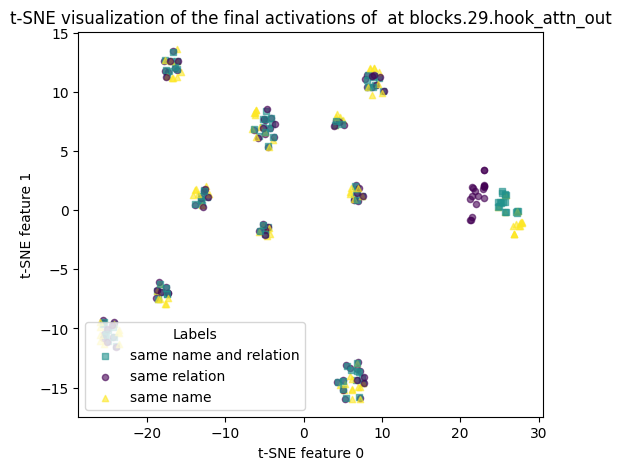

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.29.hook_attn_out',
  dimension = 2
)

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_attn_out',
  dimension = 2
)

batch_idx be:  0


OutOfMemoryError: ignored

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



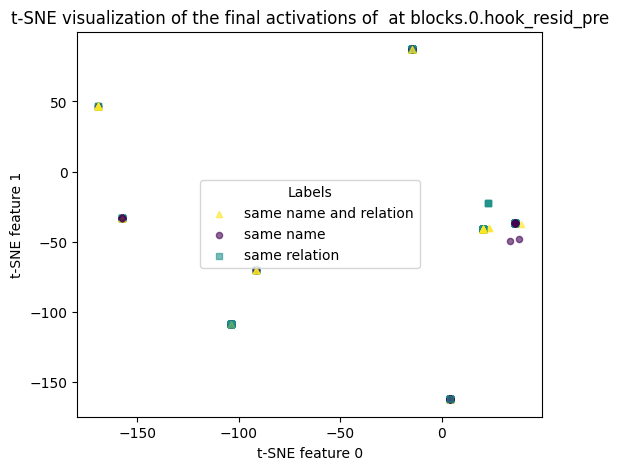

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.0.hook_resid_pre',
  dimension = 2
)

# The differences here should be explained just by different positional embeddings
# because names will be tokenised differently.

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



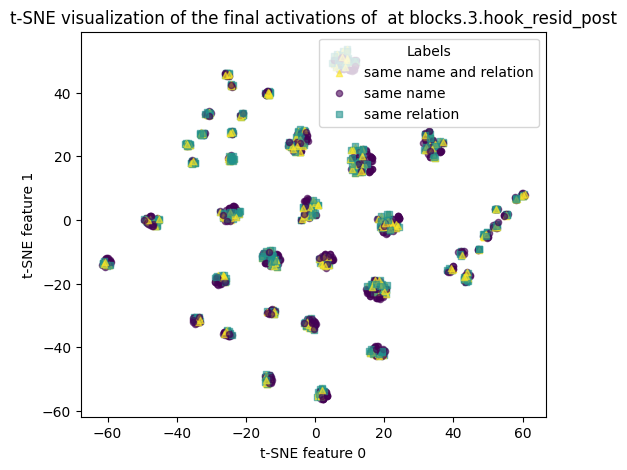

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.3.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



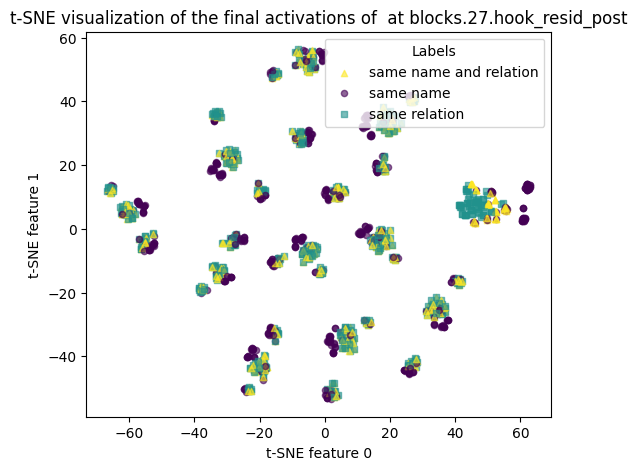

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.27.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



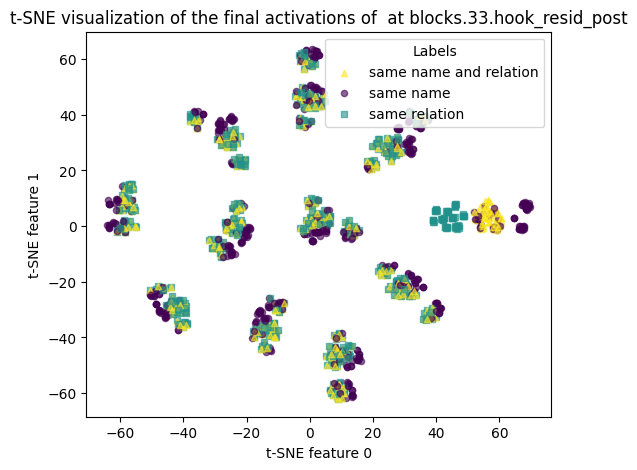

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.33.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



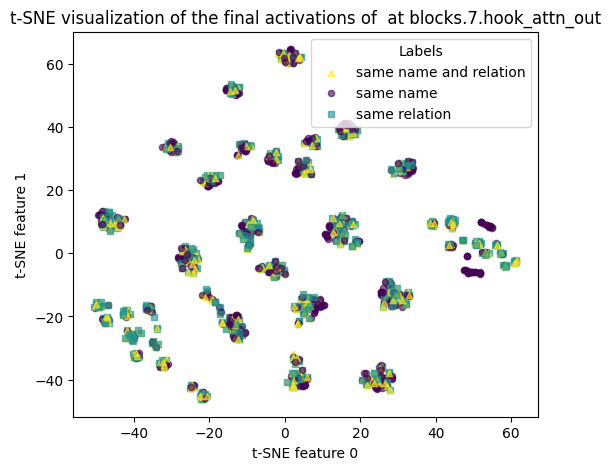

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.7.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



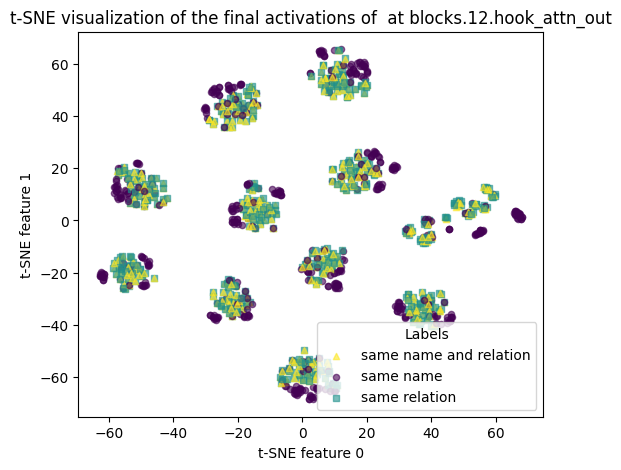

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.12.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



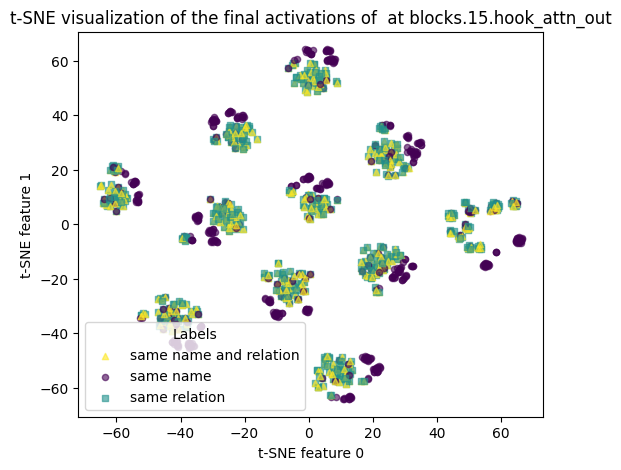

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.15.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



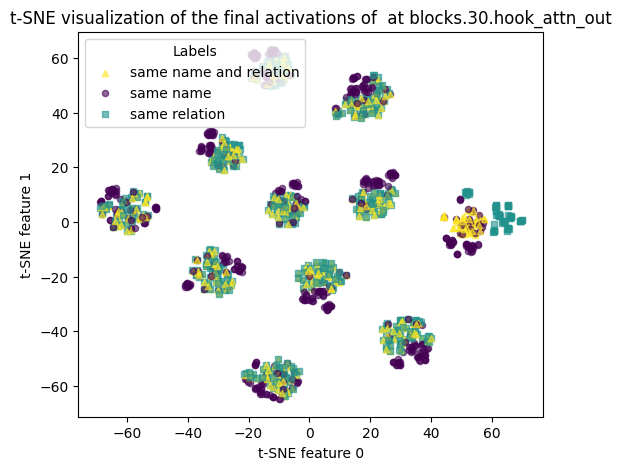

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.30.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



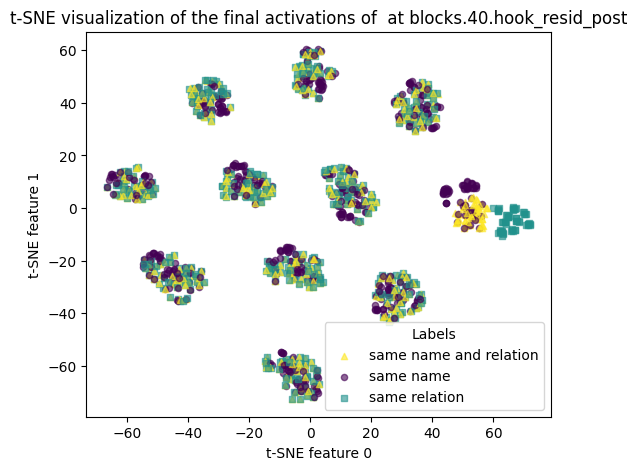

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.40.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



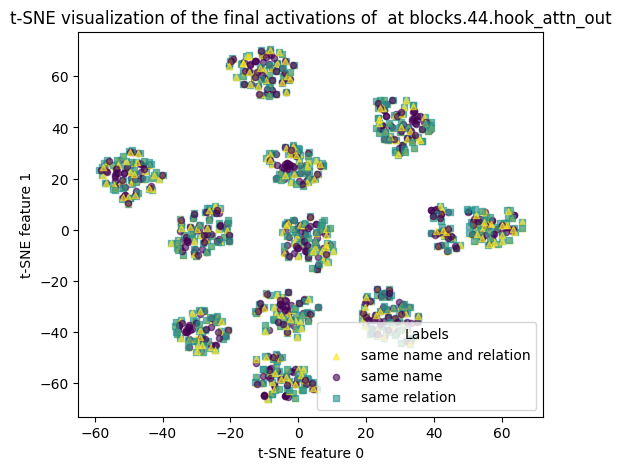

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.44.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
b

<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



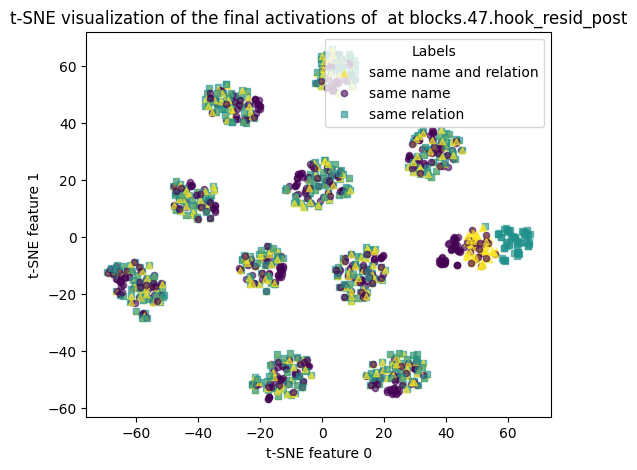

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
all data shape is:  (1000, 1600)


<ipython-input-12-1023b2ebdbbc>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



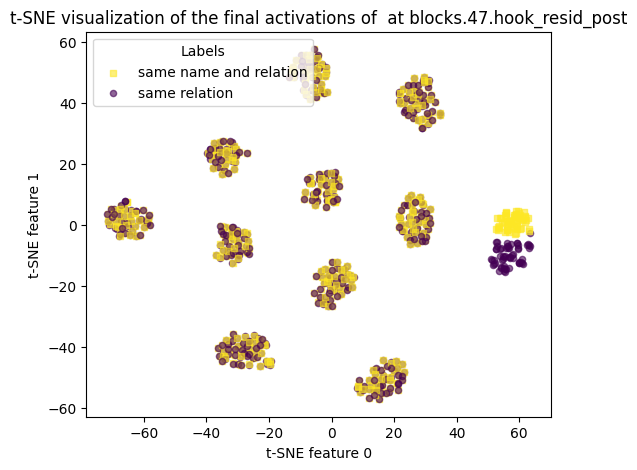

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2_3,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
all data shape is:  (500, 1600)


<ipython-input-57-307223c27c47>:92: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



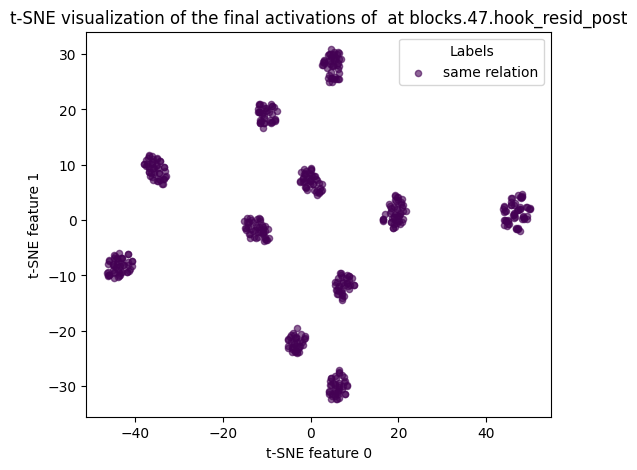

In [ ]:
_, _ = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
dataset2

["\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emily.\n  Barbara had a cousin, Aiden\n  Barbara's brother was called Brandon.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was William.\n  They had one child, Sophia.\n  Sarah had a cousin, Aiden\n  Sarah's brother was called Christopher.\n\n  The name of William's wife was Sarah.\n  The name of Sarah's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Elizabeth had a cousin, Lucas\n  Elizabeth's brother was called Matthew.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n 

In [ ]:
dataset3

["\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emily.\n  Barbara had a cousin, Aiden\n  Barbara's brother was called Taylor.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was William.\n  They had one child, Sophia.\n  Sarah had a cousin, Aiden\n  Sarah's brother was called Taylor.\n\n  The name of William's wife was Sarah.\n  The name of Sarah's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Elizabeth had a cousin, Lucas\n  Elizabeth's brother was called Taylor.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's brother was",
 "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her hu

In [ ]:
family_datasets["same name and relation"][22]

"\n  The Thompson family was renowned for their artistry.\n  Mary was the matriarch.\n  Her husband was William.\n  They had one child, Emily.\n  Mary had a cousin, Jackson\n  Mary's brother was called Taylor.\n\n  The name of William's wife was Mary.\n  The name of Mary's brother was"

In [ ]:
family_datasets.keys()

dict_keys(['same name', 'same relation', 'same name and relation'])

In [ ]:
t.cuda.empty_cache()


In [ ]:
if t.cuda.is_available():
    t.cuda.synchronize()  # Make sure all CUDA operations have completed
    t.cuda.empty_cache()

In [ ]:
import gc

gc.collect()


2637

In [ ]:
gpt2_xl

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-47): 48 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
   

# Fixed Look at the clusters


batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



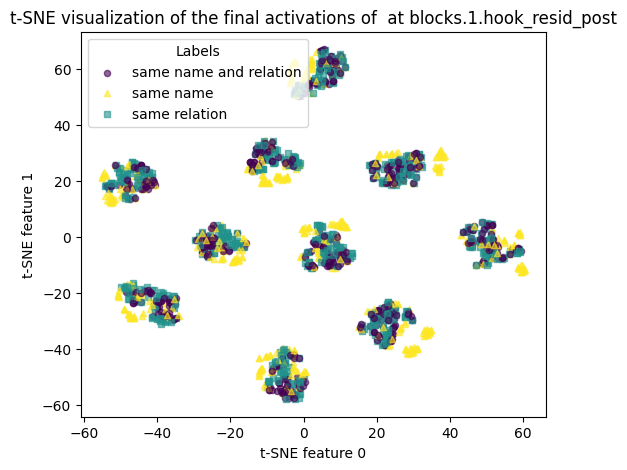

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.1.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



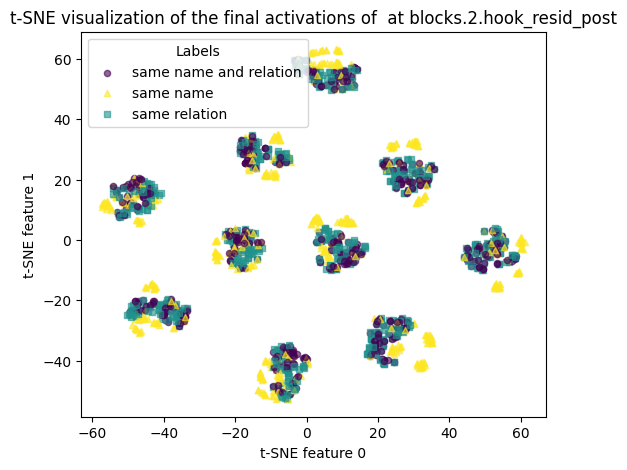

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.2.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



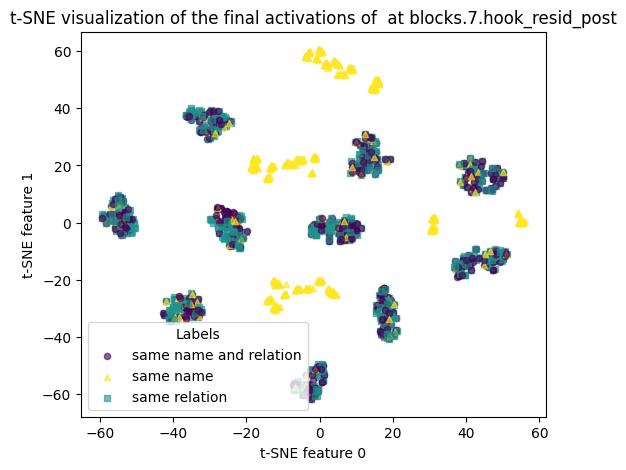

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.7.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



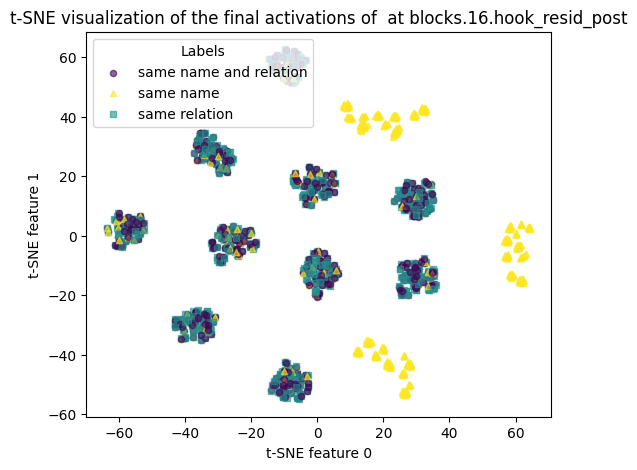

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.16.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



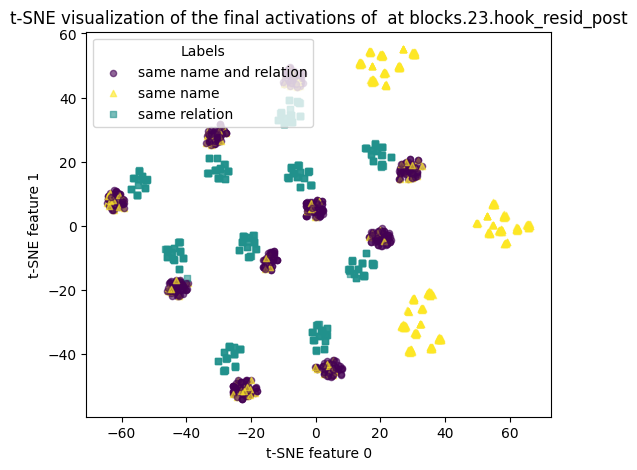

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
batch_idx be:  32
batch_idx be:  33
batch_idx be:  34
batch_idx be:  35
batch_idx be:  36
batch_idx be:  37
batch_idx be:  38
batch_idx be:  39
batch_idx be:  40
batch_idx be:  41
batch_idx be:  42
batch_idx be:  43
batch_idx be:  44
batch_idx be:  45
batch_idx be:  46
batch_idx be:  47
batch_idx be:  48
batch_idx be:  49
batch_idx be:  50
batch_idx be:  51
batch_idx be:  52
batch_idx be:  53
batch_idx be:  54
batch_idx be:  55
ba

<ipython-input-53-0feec242228c>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



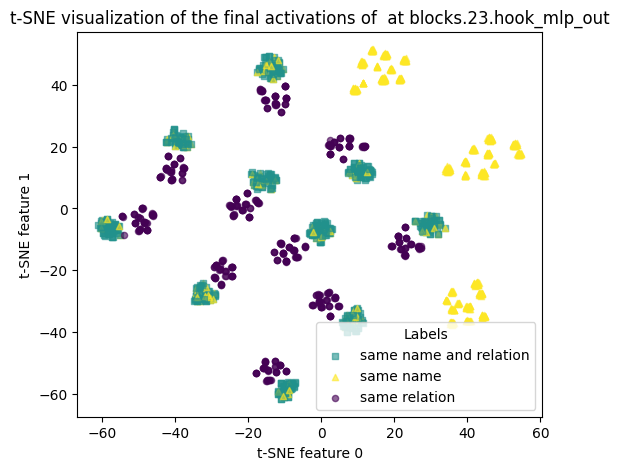

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
batch_idx be:  32
batch_idx be:  33
batch_idx be:  34
batch_idx be:  35
batch_idx be:  36
batch_idx be:  37
batch_idx be:  38
batch_idx be:  39
batch_idx be:  40
batch_idx be:  41
batch_idx be:  42
batch_idx be:  43
batch_idx be:  44
batch_idx be:  45
batch_idx be:  46
batch_idx be:  47
batch_idx be:  48
batch_idx be:  49
batch_idx be:  50
batch_idx be:  51
batch_idx be:  52
batch_idx be:  53
batch_idx be:  54
batch_idx be:  55
ba

<ipython-input-53-0feec242228c>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



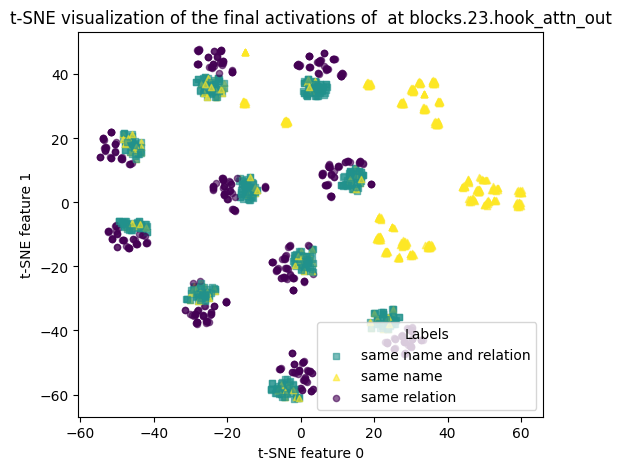

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-4-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



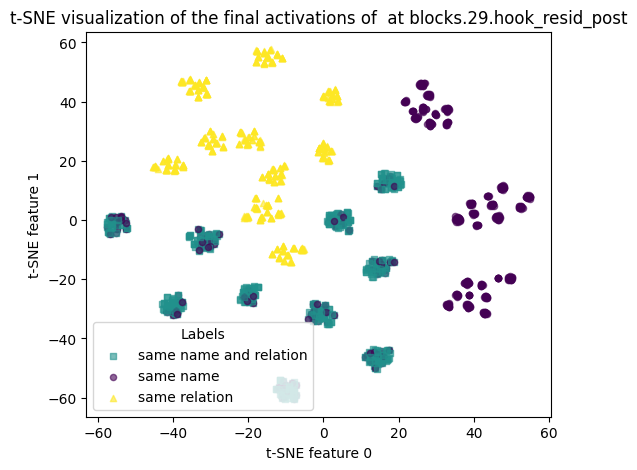

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.29.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
batch_idx be:  32
batch_idx be:  33
batch_idx be:  34
batch_idx be:  35
batch_idx be:  36
batch_idx be:  37
batch_idx be:  38
batch_idx be:  39
batch_idx be:  40
batch_idx be:  41
batch_idx be:  42
batch_idx be:  43
batch_idx be:  44
batch_idx be:  45
batch_idx be:  46
batch_idx be:  47
batch_idx be:  48
batch_idx be:  49
batch_idx be:  50
batch_idx be:  51
batch_idx be:  52
batch_idx be:  53
batch_idx be:  54
batch_idx be:  55
ba

<ipython-input-53-0feec242228c>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



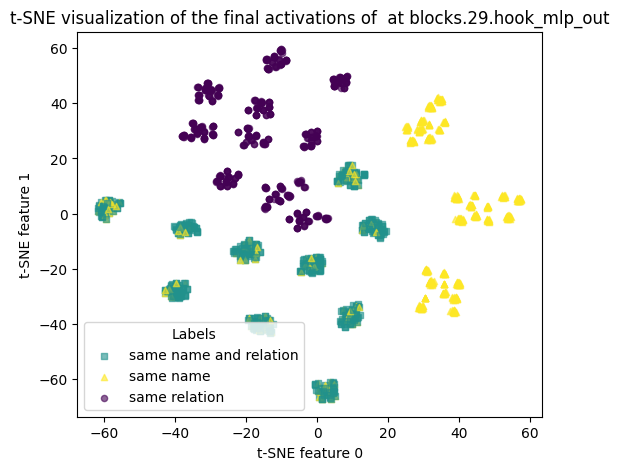

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.29.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
batch_idx be:  32
batch_idx be:  33
batch_idx be:  34
batch_idx be:  35
batch_idx be:  36
batch_idx be:  37
batch_idx be:  38
batch_idx be:  39
batch_idx be:  40
batch_idx be:  41
batch_idx be:  42
batch_idx be:  43
batch_idx be:  44
batch_idx be:  45
batch_idx be:  46
batch_idx be:  47
batch_idx be:  48
batch_idx be:  49
batch_idx be:  50
batch_idx be:  51
batch_idx be:  52
batch_idx be:  53
batch_idx be:  54
batch_idx be:  55
ba

<ipython-input-53-0feec242228c>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



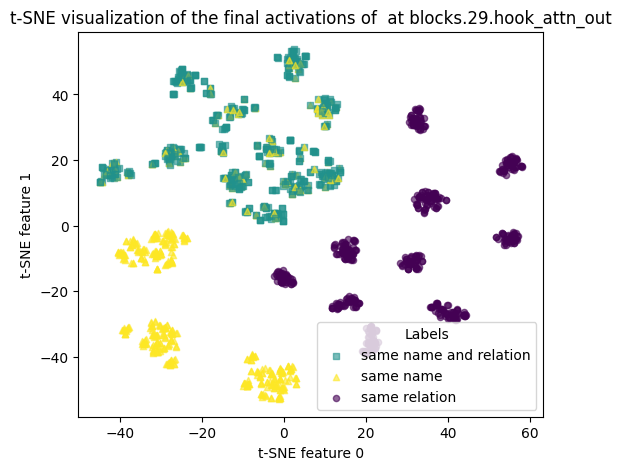

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.29.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



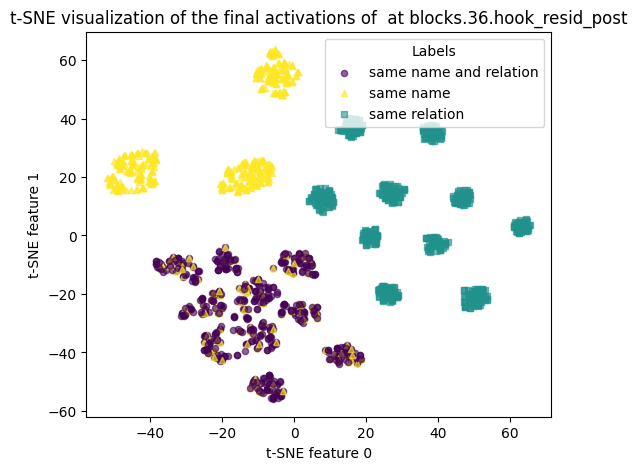

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.36.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



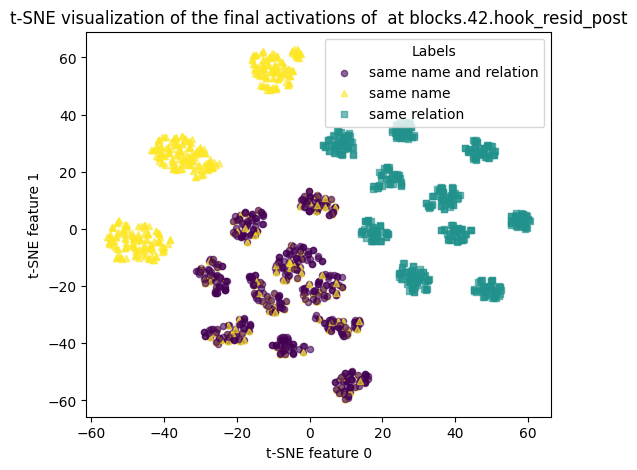

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.42.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



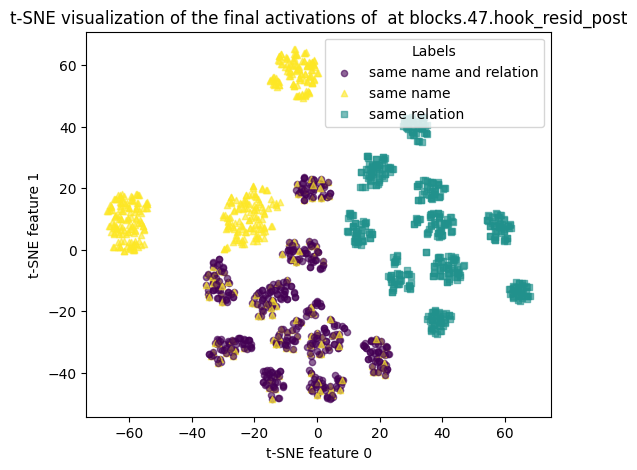

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

# Try to characterise early clusters (fixed)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



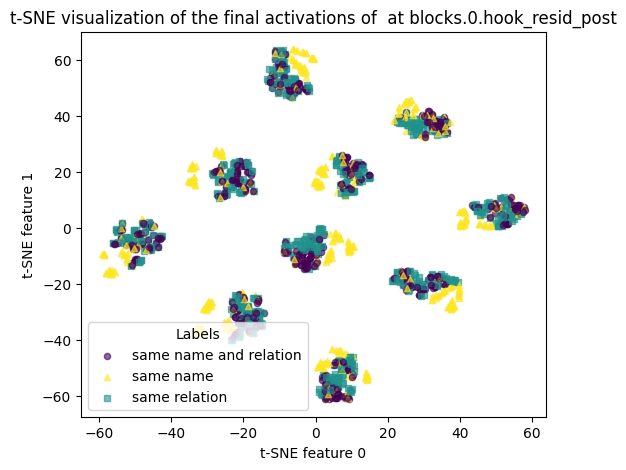

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.0.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -40

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] > 50

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([  16,   31,   54,   63,   76,   79,   81,   82,   83,  100,  142,
        157,  173,  174,  177,  187,  193,  202,  205,  236,  237,  248,
        265,  274,  278,  280,  282,  288,  293,  295,  301,  314,  318,
        326,  337,  343,  356,  366,  376,  381,  385,  392,  424,  432,
        433,  436,  442,  450,  456,  460,  463,  467,  516,  531,  554,
        563,  576,  579,  581,  582,  583,  600,  642,  657,  673,  674,
        677,  687,  693,  702,  705,  736,  737,  748,  765,  774,  778,
        780,  782,  788,  793,  795,  801,  814,  818,  826,  837,  843,
        856,  866,  876,  881,  885,  892,  924,  932,  933,  936,  942,
        950,  956,  960,  963,  967, 1016, 1031, 1054, 1063, 1076, 1079,
       1081, 1082, 1083, 1100, 1142, 1157, 1173, 1174, 1177, 1187, 1193,
       1202, 1205, 1236, 1237, 1248, 1265, 1274, 1278, 1280, 1282, 1288,
       1293, 1295, 1301, 1314, 1318, 1326, 1337, 1343, 1356, 1366, 1376,
       1381, 1385, 1392, 1424, 1432, 1433, 1436, 1

In [ ]:
dataset1[16]

"\n  The Thompson family was renowned for their artistry.\n  Jennifer was the matriarch.\n  Her husband was Taylor.\n  They had one child, Abigail.\n  Jennifer had a cousin, Aiden\n  Jennifer's brother was called Anthony.\n\n  The name of Taylor's wife was Jennifer.\n  The name of Jennifer's husband was"

In [ ]:
dataset1[31]

"\n  The Thompson family was renowned for their artistry.\n  Jennifer was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Jennifer had a cousin, Benjamin\n  Jennifer's brother was called Taylor.\n\n  The name of Robert's wife was Jennifer.\n  The name of Jennifer's brother was"

In [ ]:
dataset1[54]

"\n  The Thompson family was renowned for their artistry.\n  Jennifer was the matriarch.\n  Her husband was William.\n  They had one child, Taylor.\n  Jennifer had a cousin, Aiden\n  Jennifer's brother was called Ryan.\n\n  The name of William's wife was Jennifer.\n  The name of Jennifer's child was"

In [ ]:
dataset3[54]

"\n  The Thompson family was renowned for their artistry.\n  Jennifer was the matriarch.\n  Her husband was William.\n  They had one child, Madison.\n  Jennifer had a cousin, Aiden\n  Jennifer's brother was called Taylor.\n\n  The name of William's wife was Jennifer.\n  The name of Jennifer's brother was"

In [ ]:
import gc

gc.collect()

t.cuda.empty_cache()

I'm pretty confident that the early clusters are based on the matriarch's name. My hypothesis is that this is because the matriarch's name is the one which arises most frequently.

# Looking at clustering for MLP and attention layers (fixed)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



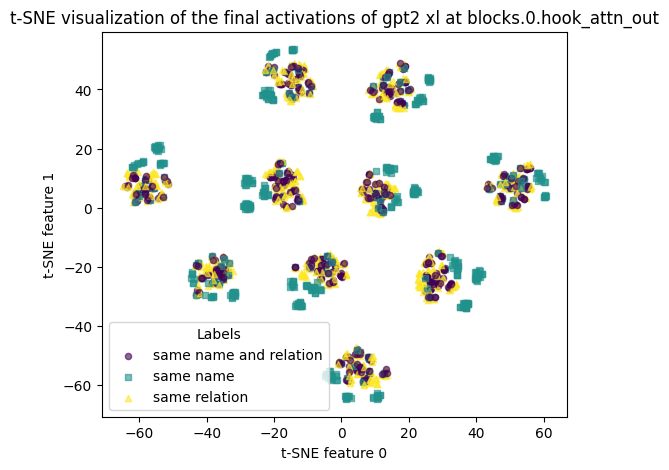

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.0.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



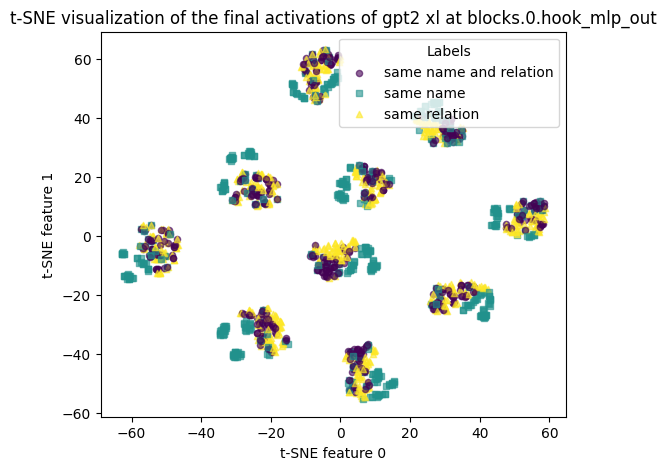

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.0.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



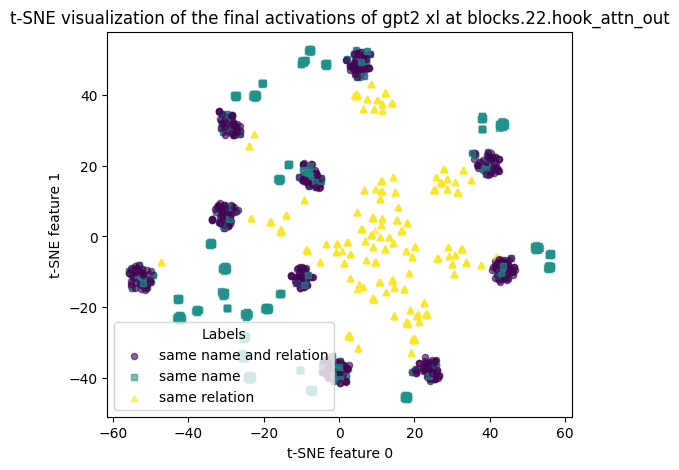

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.22.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



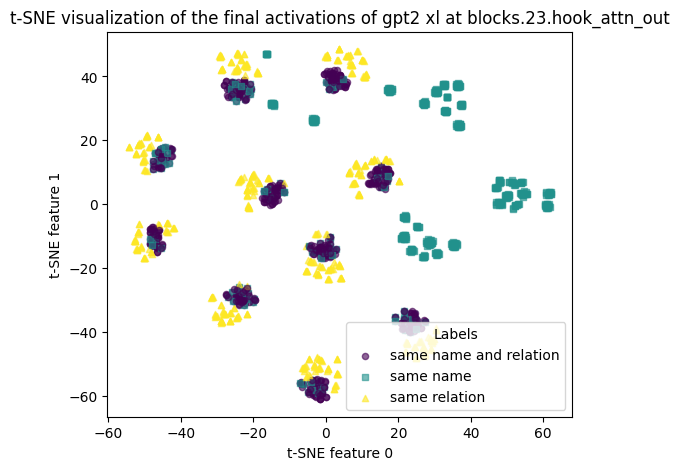

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



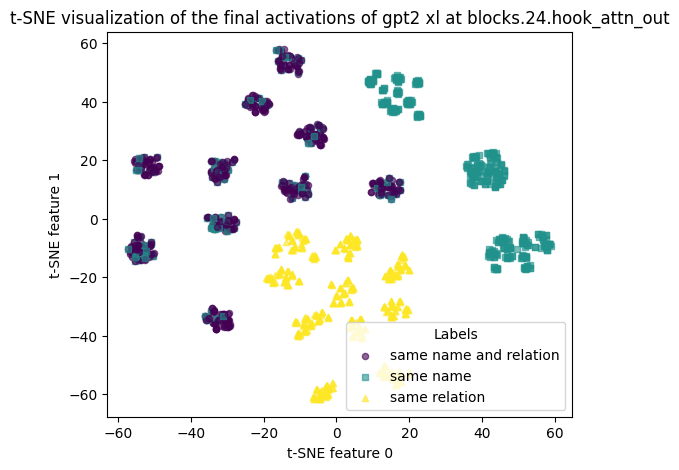

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.24.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



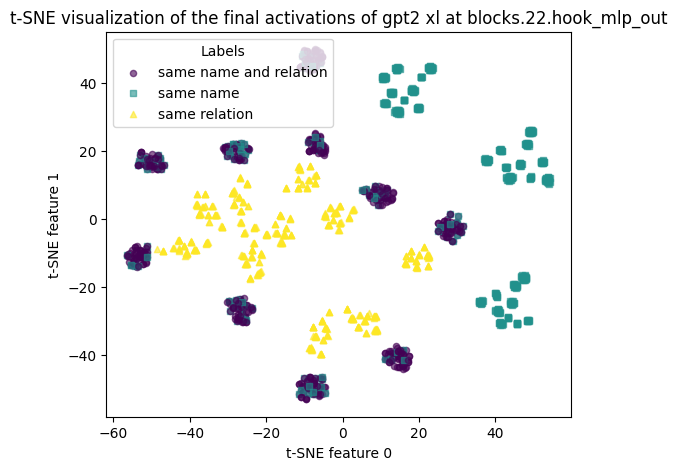

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.22.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



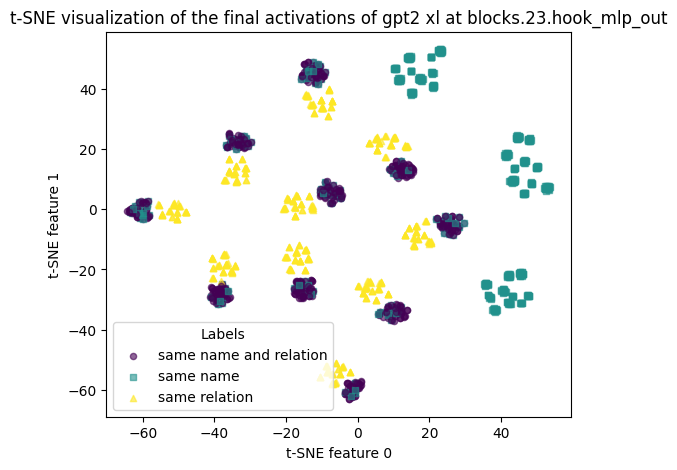

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



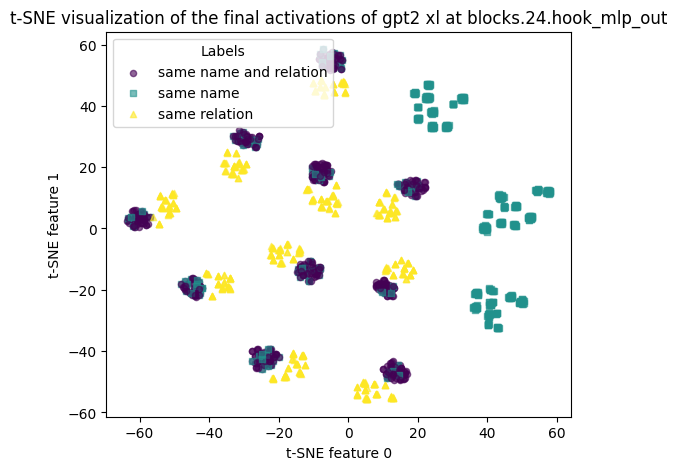

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.24.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



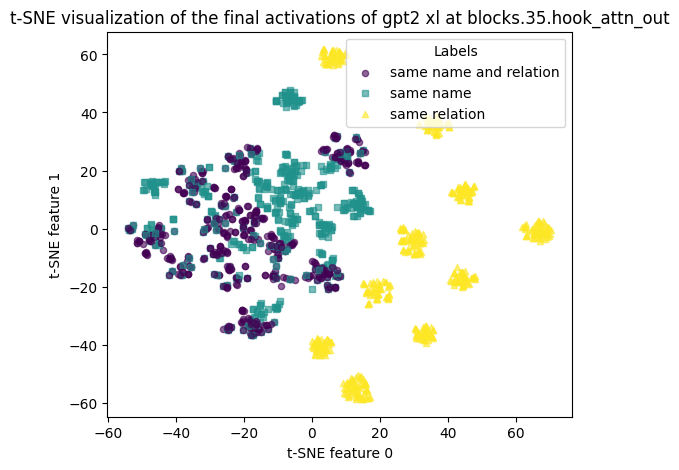

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.35.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



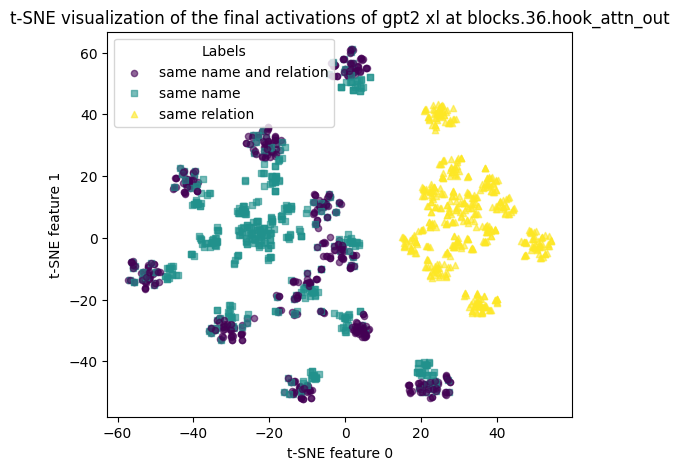

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.36.hook_attn_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



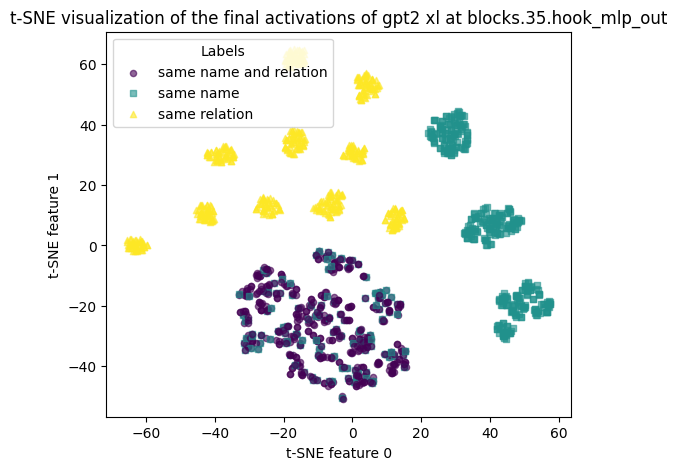

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.35.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



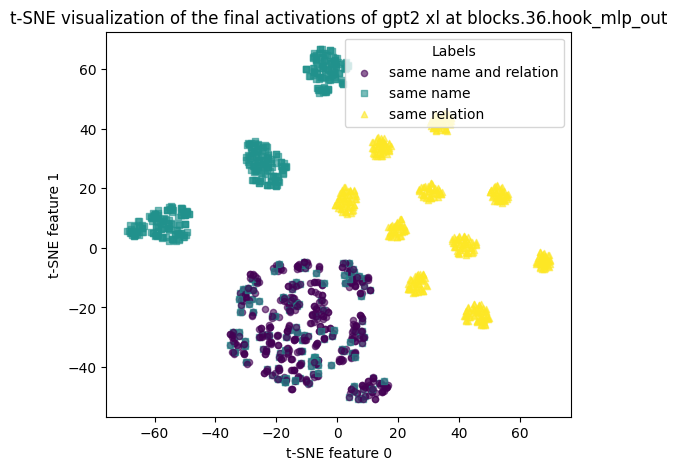

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.36.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



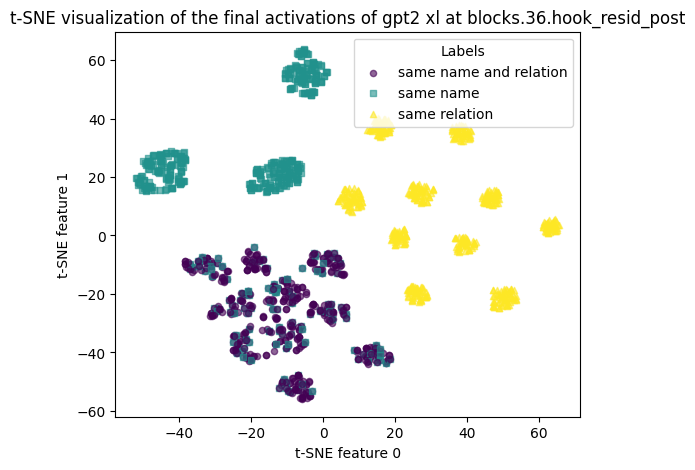

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.36.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



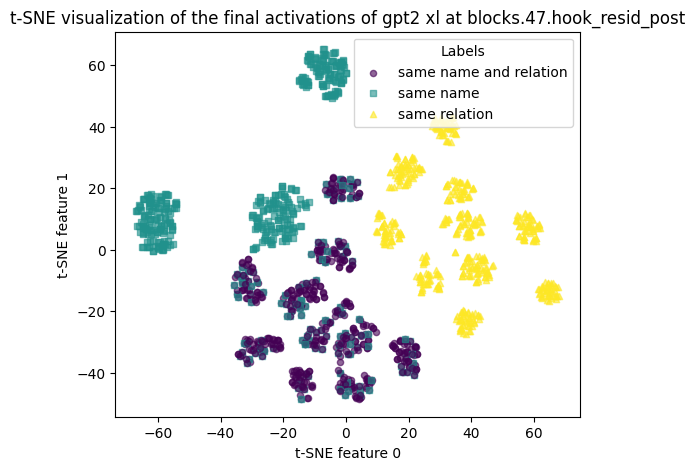

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



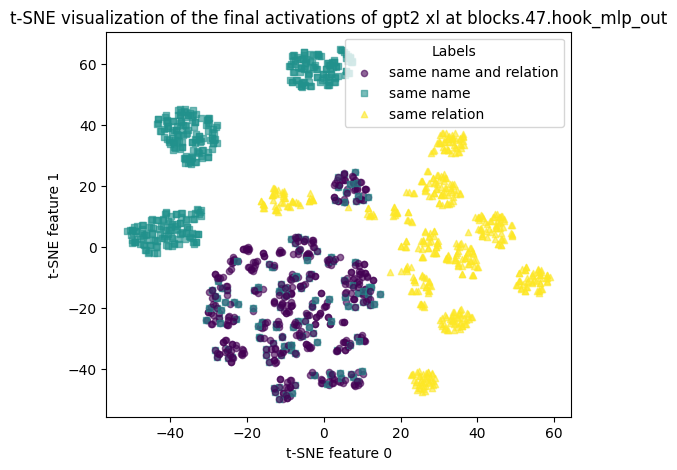

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_mlp_out',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



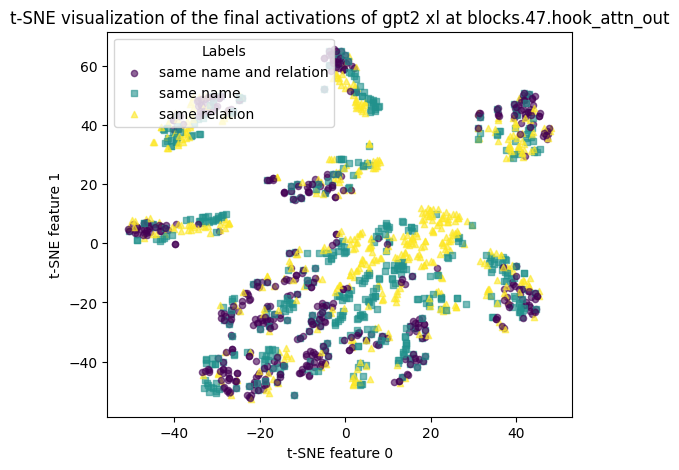

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_attn_out',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -40

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] > 50

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([  16,   31,   54,   63,   76,   79,   81,   82,   83,  100,  142,
        157,  173,  174,  177,  187,  193,  202,  205,  236,  237,  248,
        265,  274,  278,  280,  282,  288,  293,  295,  301,  314,  318,
        326,  337,  343,  356,  366,  376,  381,  385,  392,  424,  432,
        433,  436,  442,  450,  456,  460,  463,  467,  516,  531,  554,
        563,  576,  579,  581,  582,  583,  600,  642,  657,  673,  674,
        677,  687,  693,  702,  705,  736,  737,  748,  765,  774,  778,
        780,  782,  788,  793,  795,  801,  814,  818,  826,  837,  843,
        856,  866,  876,  881,  885,  892,  924,  932,  933,  936,  942,
        950,  956,  960,  963,  967, 1016, 1031, 1054, 1063, 1076, 1079,
       1081, 1082, 1083, 1100, 1142, 1157, 1173, 1174, 1177, 1187, 1193,
       1202, 1205, 1236, 1237, 1248, 1265, 1274, 1278, 1280, 1282, 1288,
       1293, 1295, 1301, 1314, 1318, 1326, 1337, 1343, 1356, 1366, 1376,
       1381, 1385, 1392, 1424, 1432, 1433, 1436, 1

In [ ]:
import gc

gc.collect()

t.cuda.empty_cache()

I'm pretty confident that the early clusters are based on the matriarch's name. My hypothesis is that this is because the matriarch's name is the one which arises most frequently.

# Try to characterise later clusters (fixed)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



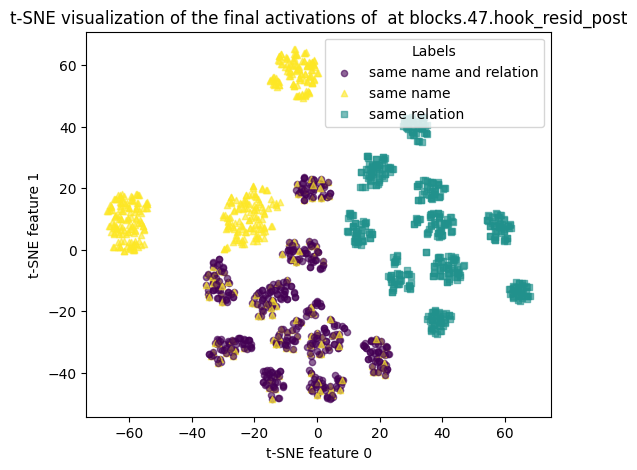

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -45

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] > 50

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([  2,  14,  29,  35,  37,  40,  41,  45,  47,  48,  50,  53,  59,
        61,  62,  66,  67,  69,  70,  72,  74,  80,  84,  86,  87,  90,
        92,  93,  96, 100, 105, 107, 110, 113, 115, 122, 131, 133, 138,
       142, 145, 148, 153, 158, 160, 166, 176, 179, 182, 184, 188, 193,
       200, 201, 207, 208, 210, 211, 212, 218, 219, 225, 229, 232, 240,
       243, 244, 245, 248, 261, 262, 265, 272, 273, 275, 276, 280, 284,
       292, 299, 300, 301, 303, 308, 310, 314, 318, 320, 322, 334, 336,
       337, 344, 346, 348, 349, 350, 351, 357, 359, 362, 373, 375, 379,
       396, 397, 398, 403, 410, 412, 414, 416, 418, 421, 428, 433, 434,
       436, 438, 444, 445, 452, 454, 457, 460, 474, 476, 478, 485, 487,
       490, 491, 493, 494, 497, 498]),)


In [ ]:
indices[0].shape

(136,)

In [ ]:
dataset1[2]

"\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Elizabeth had a cousin, Taylor\n  Elizabeth's brother was called Matthew.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's cousin was"

In [ ]:
dataset1[14]

"\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was John.\n  They had one child, Madison.\n  Sarah had a cousin, Taylor\n  Sarah's brother was called Nicholas.\n\n  The name of John's wife was Sarah.\n  The name of Sarah's cousin was"

In [ ]:
gpt2_xl.to_tokens(dataset3[35]).shape

In [ ]:
dataset1[29]

"\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was David.\n  They had one child, Isabella.\n  Elizabeth had a cousin, Taylor\n  Elizabeth's brother was called Kevin.\n\n  The name of David's wife was Elizabeth.\n  The name of Elizabeth's cousin was"

In [ ]:
gpt2_xl.to_tokens(dataset1[29]).shape

torch.Size([1, 76])

In [ ]:
dataset1[35]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was David.\n  They had one child, Olivia.\n  Linda had a cousin, Taylor\n  Linda's brother was called Matthew.\n\n  The name of David's wife was Linda.\n  The name of Linda's cousin was"

In [ ]:
gpt2_xl.to_tokens(dataset1[35]).shape

torch.Size([1, 75])

In [ ]:
import gc

gc.collect()

t.cuda.empty_cache()

It looks like, for the dataset where the relation changes but the name is always Taylor, we have clusters based on the relation. I'd guess that the intersections between same name and same name and relations clusters is where the relation is "brother" between the two datasets.

It's interesting that we are not getting separation based on the output for these clusters. I'm pretty sure there was no overlap between the names we used for different relations, so maybe we actually are still getting these clusters (just less obviously)?

# Looking at individual datasets

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
all data shape is:  (500, 1600)


<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



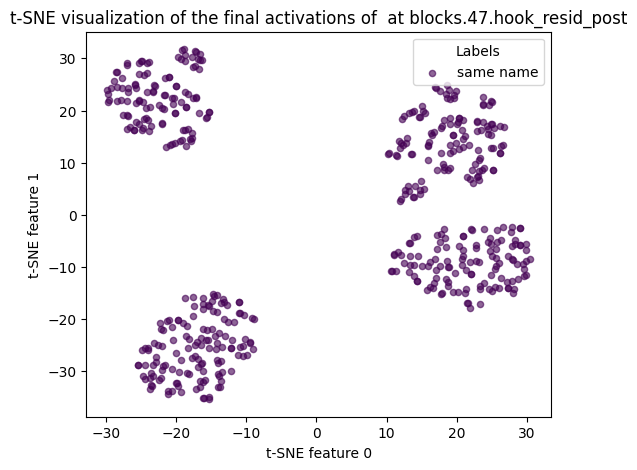

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_1,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
all data shape is:  (500, 1600)


<ipython-input-5-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



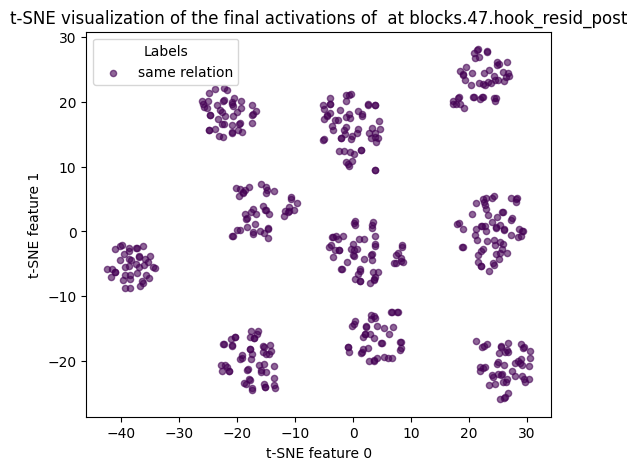

In [ ]:
tsne_data_fam_dataset_2_end, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data_fam_dataset_2_end[:, 0] < -30

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data_fam_dataset_2_end[:, 1] > 50

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([ 14,  17,  23,  56,  60,  71,  76,  87,  94, 118, 123, 135, 139,
       142, 148, 150, 180, 183, 192, 201, 209, 221, 263, 269, 270, 275,
       276, 305, 322, 351, 363, 370, 385, 402, 406, 413, 417, 439, 443,
       474, 481]),)


In [ ]:
dataset2[14]

"\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was John.\n  They had one child, Madison.\n  Sarah had a cousin, Alexander\n  Sarah's brother was called Nicholas.\n\n  The name of John's wife was Sarah.\n  The name of Sarah's brother was"

In [ ]:
dataset2[17]

"\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was David.\n  They had one child, Ava.\n  Barbara had a cousin, Lucas\n  Barbara's brother was called Nicholas.\n\n  The name of David's wife was Barbara.\n  The name of Barbara's brother was"

In [ ]:
dataset2[23]

"\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Richard.\n  They had one child, Emily.\n  Elizabeth had a cousin, Jackson\n  Elizabeth's brother was called Nicholas.\n\n  The name of Richard's wife was Elizabeth.\n  The name of Elizabeth's brother was"

In [ ]:
dataset2[56]

"\n  The Thompson family was renowned for their artistry.\n  Margaret was the matriarch.\n  Her husband was David.\n  They had one child, Abigail.\n  Margaret had a cousin, Elijah\n  Margaret's brother was called Nicholas.\n\n  The name of David's wife was Margaret.\n  The name of Margaret's brother was"

It looks like dataset 2 (relation is always brother) is being separated based on output name: this cluster is for Nicholas.

In [ ]:
family_datasets_3

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1600])
data numpy shape is:  (500, 1600)
all data shape is:  (500, 1600)


<ipython-input-4-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



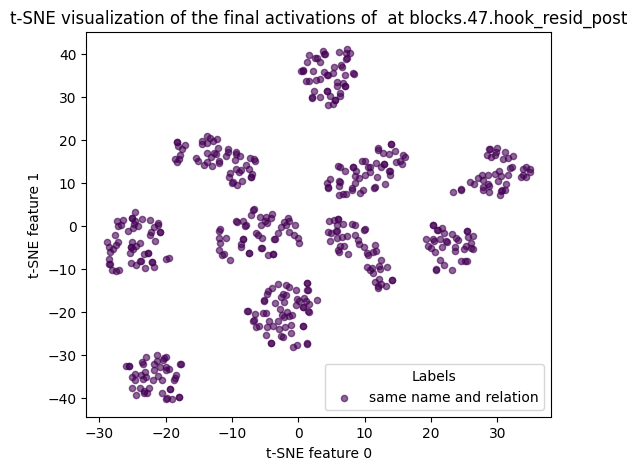

In [ ]:
tsne_data_3, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_3,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data_3[:, 0] < -15

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data_3[:, 1] > 30

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition2)

print(indices)

(array([ 10,  11,  43,  67,  70,  75, 113, 130, 141, 142, 145, 147, 164,
       174, 186, 192, 216, 221, 227, 233, 244, 248, 262, 265, 266, 272,
       279, 288, 289, 301, 313, 320, 328, 338, 343, 378, 397, 442, 451,
       453, 475, 481, 485]),)


In [ ]:
indices[0].shape

(43,)

In [ ]:
dataset3[10]

"\n  The Thompson family was renowned for their artistry.\n  Margaret was the matriarch.\n  Her husband was Thomas.\n  They had one child, Mia.\n  Margaret had a cousin, Mason\n  Margaret's brother was called Taylor.\n\n  The name of Thomas's wife was Margaret.\n  The name of Margaret's brother was"

In [ ]:
dataset3[11]

"\n  The Thompson family was renowned for their artistry.\n  Jessica was the matriarch.\n  Her husband was Michael.\n  They had one child, Abigail.\n  Jessica had a cousin, Mason\n  Jessica's brother was called Taylor.\n\n  The name of Michael's wife was Jessica.\n  The name of Jessica's brother was"

In [ ]:
dataset3[43]

"\n  The Thompson family was renowned for their artistry.\n  Patricia was the matriarch.\n  Her husband was Robert.\n  They had one child, Olivia.\n  Patricia had a cousin, Mason\n  Patricia's brother was called Taylor.\n\n  The name of Robert's wife was Patricia.\n  The name of Patricia's brother was"

In [ ]:
dataset3[67]

"\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was John.\n  They had one child, Mia.\n  Elizabeth had a cousin, Mason\n  Elizabeth's brother was called Taylor.\n\n  The name of John's wife was Elizabeth.\n  The name of Elizabeth's brother was"

This seems to be clustering based on the name of the cousin, Mason? This is kind of weird!

In [ ]:
condition1 = tsne_data_3[:, 0] < -15

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data_3[:, 1] < -30

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition2)

print(indices)

(array([  3,   8,  41,  51,  60,  83,  88,  89,  91,  95, 100, 124, 157,
       161, 169, 187, 194, 197, 200, 207, 210, 225, 271, 298, 309, 312,
       314, 336, 341, 357, 363, 366, 374, 376, 383, 387, 388, 391, 395,
       409, 430, 441, 459, 462, 470, 474]),)


In [ ]:
dataset3[3]

"\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was James.\n  They had one child, Madison.\n  Sarah had a cousin, Liam\n  Sarah's brother was called Taylor.\n\n  The name of James's wife was Sarah.\n  The name of Sarah's brother was"

In [ ]:
dataset3[8]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was James.\n  They had one child, Mia.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of James's wife was Linda.\n  The name of Linda's brother was"

In [ ]:
dataset3[41]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's brother was"

This is clustering based on Liam! Worth checking the log probs for cousins to see if the model is giving them high log probs.

Also worth noting that when I put dataset3[41] into the playground for davinci the second most likely token is Liam. For the weaker GPT-3 models, the most likely token is Liam!

The cousin being the second most likely / most likely for weaker models seems to hold for the other examples I tested in the playground, even when I changed the relation from cousin to grandfather.

In [ ]:
gpt2_xl.generate(dataset3[41], max_new_tokens=10, temperature=0, prepend_bos=True)

  0%|          | 0/10 [00:00<?, ?it/s]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's brother was Taylor.\n  The name of Taylor's wife"

In [ ]:
gpt2_xl.generate(dataset3[41], max_new_tokens=10, temperature=0, prepend_bos=True)

  0%|          | 0/10 [00:00<?, ?it/s]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's brother was Taylor.\n  The name of Taylor's wife"

# Repeating Experiment with gpt2 large

In [ ]:
gpt2_large = HookedTransformer.from_pretrained("gpt2-large").cuda()

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer
Moving model to device:  cuda


batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
all final activations shape is:  torch.Size([500, 1280])
data numpy shape is:  (500, 1280)
batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx b

<ipython-input-4-00fdce994277>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



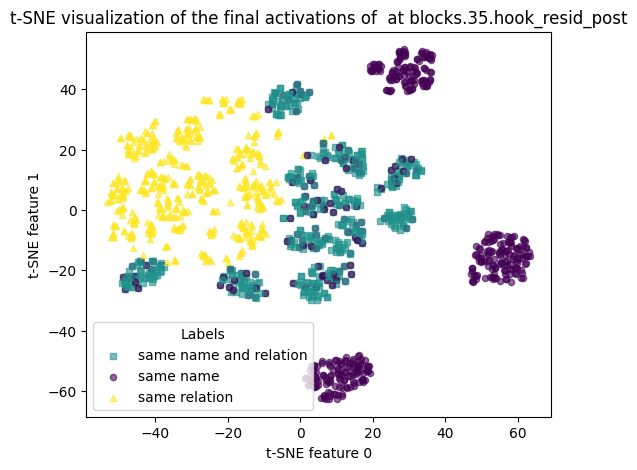

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_large,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.35.hook_resid_post',
  dimension = 2
)

In [ ]:
dataset3[41]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's brother was"

In [ ]:
gpt2_large.generate(dataset3[41], max_new_tokens=10, temperature=0, prepend_bos=True)

  0%|          | 0/10 [00:00<?, ?it/s]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's brother was Joseph.\n  The name of Joseph's wife"

In [ ]:
dataset3[99]

"\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Barbara had a cousin, Jackson\n  Barbara's brother was called Taylor.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's brother was"

In [ ]:
gpt2_large.generate(dataset3[99], max_new_tokens=10, temperature=0, prepend_bos=True)

  0%|          | 0/10 [00:00<?, ?it/s]

"\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Barbara had a cousin, Jackson\n  Barbara's brother was called Taylor.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's brother was Joseph.\n  Joseph's wife was called Mary"

In [ ]:
gpt2_large.generate(dataset3[41], max_new_tokens=10, temperature=0, prepend_bos=True)

# Try to characterise the clusters

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
batch_idx be:  25
batch_idx be:  26
batch_idx be:  27
batch_idx be:  28
batch_idx be:  29
batch_idx be:  30
batch_idx be:  31
batch_idx be:  32
batch_idx be:  33
batch_idx be:  34
batch_idx be:  35
batch_idx be:  36
batch_idx be:  37
batch_idx be:  38
batch_idx be:  39
batch_idx be:  40
batch_idx be:  41
batch_idx be:  42
batch_idx be:  43
batch_idx be:  44
batch_idx be:  45
batch_idx be:  46
batch_idx be:  47
batch_idx be:  48
batch_idx be:  49
batch_idx be:  50
batch_idx be:  51
batch_idx be:  52
batch_idx be:  53
batch_idx be:  54
batch_idx be:  55
ba

<ipython-input-53-0feec242228c>:93: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



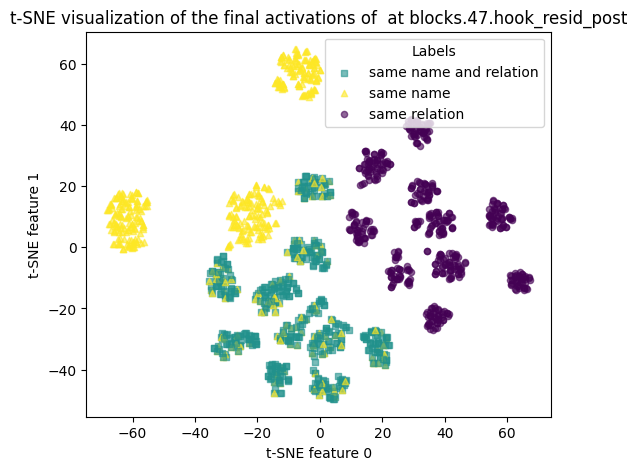

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < 0

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] < -40

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(combined_condition)

print(indices)

(array([   8,   34,   35,   41,   48,   49,   57,   77,   96,  105,  111,
        131,  182,  201,  211,  214,  215,  227,  243,  247,  255,  263,
        270,  271,  272,  279,  297,  328,  333,  357,  372,  375,  380,
        388,  393,  395,  414,  418,  420,  426,  439,  452,  457,  470,
        473,  487,  508,  534,  535,  541,  548,  549,  557,  577,  596,
        605,  631,  633,  682,  701,  711,  714,  715,  723,  727,  743,
        747,  755,  763,  770,  771,  772,  779,  797,  833,  857,  872,
        875,  880,  888,  893,  895,  914,  918,  920,  926,  939,  952,
        957,  970,  973,  987, 1008, 1034, 1035, 1041, 1048, 1049, 1057,
       1077, 1096, 1105, 1131, 1133, 1182, 1201, 1211, 1214, 1215, 1223,
       1227, 1243, 1247, 1255, 1263, 1270, 1271, 1272, 1279, 1297, 1333,
       1357, 1372, 1375, 1380, 1388, 1393, 1395, 1414, 1418, 1420, 1426,
       1439, 1452, 1457, 1470, 1473, 1487]),)


In [ ]:
dataset1[8]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was James.\n  They had one child, Mia.\n  Linda had a cousin, Liam\n  Linda's brother was called Taylor.\n\n  The name of James's wife was Linda.\n  The name of Linda's brother was"

In [ ]:
dataset1[34]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was David.\n  They had one child, Charlotte.\n  Linda had a cousin, Ethan\n  Linda's brother was called Taylor.\n\n  The name of David's wife was Linda.\n  The name of Linda's brother was"

In [ ]:
dataset1[35]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was David.\n  They had one child, Olivia.\n  Linda had a cousin, Taylor\n  Linda's brother was called Matthew.\n\n  The name of David's wife was Linda.\n  The name of Linda's cousin was"

In [ ]:
dataset1[41]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Joseph.\n  They had one child, Emma.\n  Linda had a cousin, Taylor\n  Linda's brother was called Anthony.\n\n  The name of Joseph's wife was Linda.\n  The name of Linda's cousin was"

In [ ]:
dataset1[48]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was David.\n  They had one child, Olivia.\n  Linda had a cousin, Taylor\n  Linda's brother was called Brandon.\n\n  The name of David's wife was Linda.\n  The name of Linda's cousin was"

In [ ]:
dataset2[77]

"\n  The Thompson family was renowned for their artistry.\n  Linda was the matriarch.\n  Her husband was Richard.\n  They had one child, Emma.\n  Linda had a cousin, Alexander\n  Linda's brother was called Andrew.\n\n  The name of Richard's wife was Linda.\n  The name of Linda's brother was"

In [ ]:
dataset[35]

In [ ]:
dataset1[69]

"\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Olivia.\n  Elizabeth had a cousin, Taylor\n  Elizabeth's brother was called Kevin.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's cousin was"

In [ ]:
testo = dataset1[48]

In [ ]:
tsne_data.shape

(1500, 2)

In [ ]:
import gc

gc.collect()

t.cuda.empty_cache()

My datasets are wafty as hell!!!! Check these lmaooo

(They might also not be, might just be a weird design!)

# Try to characterise the clusters for different names as output

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
all data shape is:  (500, 1600)


<ipython-input-57-307223c27c47>:92: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



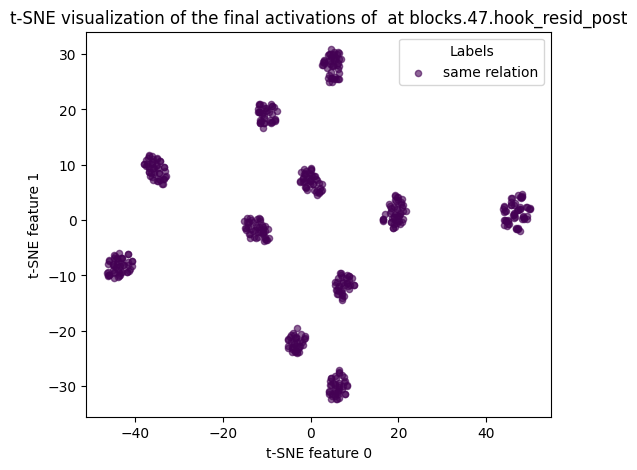

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -30

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] > -40

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([], dtype=int64),)


In [ ]:
indices[0][0]

11

In [ ]:
for index in indices[0]:
  print(dataset2[index])


  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Michael.
  They had one child, Abigail.
  Jessica had a cousin, Mason
  Jessica's brother was called Brandon.

  The name of Michael's wife was Jessica.
  The name of Jessica's brother was

  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Robert.
  They had one child, Sophia.
  Jessica had a cousin, Elijah
  Jessica's brother was called Andrew.

  The name of Robert's wife was Jessica.
  The name of Jessica's brother was

  The Thompson family was renowned for their artistry.
  Jennifer was the matriarch.
  Her husband was Robert.
  They had one child, Sophia.
  Jennifer had a cousin, Benjamin
  Jennifer's brother was called Matthew.

  The name of Robert's wife was Jennifer.
  The name of Jennifer's brother was

  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Joseph.
  They had 

This seems to be a cluster for the start of Jennifer + Jessica (the matriarch).

Think this is actually two clusters, which could explain it? (would be cool if this is why they are close?)

# Try to characterise the clusters for different names as output

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
all data shape is:  (500, 1600)


<ipython-input-57-307223c27c47>:92: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



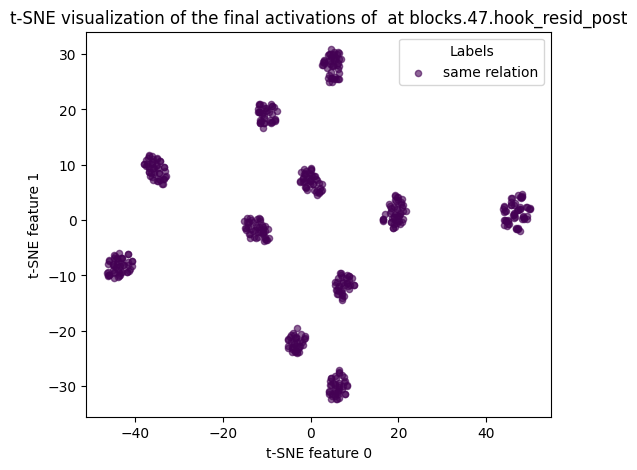

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -40

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] > -40

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition1)

print(indices)

(array([ 11,  19,  44,  51,  68,  71,  74,  86,  92,  95, 116, 124, 129,
       134, 145, 155, 160, 168, 169, 191, 208, 219, 233, 235, 246, 253,
       254, 259, 262, 266, 268, 291, 298, 302, 320, 332, 334, 336, 349,
       359, 362, 377, 383, 400, 438, 446, 447, 479, 488, 490]),)


In [ ]:
indices[0][0]

11

In [ ]:
for index in indices[0]:
  print(dataset2[index])


  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Michael.
  They had one child, Abigail.
  Jessica had a cousin, Mason
  Jessica's brother was called Brandon.

  The name of Michael's wife was Jessica.
  The name of Jessica's brother was

  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Robert.
  They had one child, Sophia.
  Jessica had a cousin, Elijah
  Jessica's brother was called Andrew.

  The name of Robert's wife was Jessica.
  The name of Jessica's brother was

  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was Joseph.
  They had one child, Madison.
  Jessica had a cousin, Noah
  Jessica's brother was called Matthew.

  The name of Joseph's wife was Jessica.
  The name of Jessica's brother was

  The Thompson family was renowned for their artistry.
  Jessica was the matriarch.
  Her husband was James.
  They had one child

This seems to be a cluster for just Jessica (the matriarch).

# Try to characterise the clusters for different names as output

batch_idx be:  0
batch_idx be:  1
batch_idx be:  2
batch_idx be:  3
batch_idx be:  4
batch_idx be:  5
batch_idx be:  6
batch_idx be:  7
batch_idx be:  8
batch_idx be:  9
batch_idx be:  10
batch_idx be:  11
batch_idx be:  12
batch_idx be:  13
batch_idx be:  14
batch_idx be:  15
batch_idx be:  16
batch_idx be:  17
batch_idx be:  18
batch_idx be:  19
batch_idx be:  20
batch_idx be:  21
batch_idx be:  22
batch_idx be:  23
batch_idx be:  24
all data shape is:  (500, 1600)


<ipython-input-57-307223c27c47>:92: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



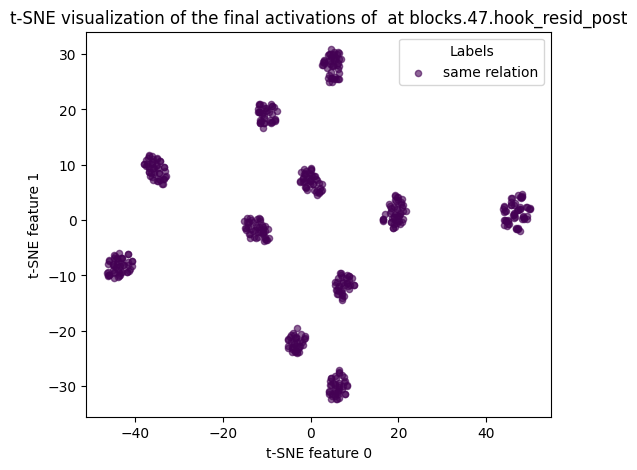

In [ ]:
tsne_data, labels = activation_plot_final_acts_optimised(
  model = gpt2_xl,
  datasets_lang = family_datasets_2,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)

In [ ]:
condition1 = tsne_data[:, 0] < -40

# Define the condition for the second feature (column 1) being less than -40
condition2 = tsne_data[:, 1] < -30

# Combine the conditions using logical AND
combined_condition = condition1 & condition2

# Find the indices of points that meet both conditions
indices = np.nonzero(condition2)

print(indices)

(array([  2,  37,  47, 180, 181, 183, 194, 204, 206, 232, 238, 276, 330,
       355, 373, 417, 425, 429, 434, 461, 466]),)


In [ ]:
indices[0][0]

11

In [ ]:
for index in indices[0]:
  print(dataset2[index])


  The Thompson family was renowned for their artistry.
  Elizabeth was the matriarch.
  Her husband was Robert.
  They had one child, Sophia.
  Elizabeth had a cousin, Lucas
  Elizabeth's brother was called Matthew.

  The name of Robert's wife was Elizabeth.
  The name of Elizabeth's brother was

  The Thompson family was renowned for their artistry.
  Elizabeth was the matriarch.
  Her husband was Thomas.
  They had one child, Charlotte.
  Elizabeth had a cousin, Elijah
  Elizabeth's brother was called Daniel.

  The name of Thomas's wife was Elizabeth.
  The name of Elizabeth's brother was

  The Thompson family was renowned for their artistry.
  Elizabeth was the matriarch.
  Her husband was Charles.
  They had one child, Mia.
  Elizabeth had a cousin, Elijah
  Elizabeth's brother was called Ryan.

  The name of Charles's wife was Elizabeth.
  The name of Elizabeth's brother was

  The Thompson family was renowned for their artistry.
  Elizabeth was the matriarch.
  Her husband wa

This seems to be a cluster for just Elizabeth (the matriarch).

# GPT-2 Small Test

In [ ]:
gpt2_small = HookedTransformer.from_pretrained("gpt2-small").cuda()

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


batch_idx be:  0
["\n  The Thompson family was renowned for their artistry.\n  Barbara was the matriarch.\n  Her husband was Joseph.\n  They had one child, Taylor.\n  Barbara had a cousin, Aiden\n  Barbara's brother was called Brandon.\n\n  The name of Joseph's wife was Barbara.\n  The name of Barbara's child was", "\n  The Thompson family was renowned for their artistry.\n  Sarah was the matriarch.\n  Her husband was William.\n  They had one child, Taylor.\n  Sarah had a cousin, Aiden\n  Sarah's brother was called Christopher.\n\n  The name of William's wife was Sarah.\n  The name of Sarah's child was", "\n  The Thompson family was renowned for their artistry.\n  Elizabeth was the matriarch.\n  Her husband was Robert.\n  They had one child, Sophia.\n  Elizabeth had a cousin, Taylor\n  Elizabeth's brother was called Matthew.\n\n  The name of Robert's wife was Elizabeth.\n  The name of Elizabeth's cousin was", "\n  The Thompson family was renowned for their artistry.\n  Sarah was the ma

<ipython-input-51-2ff6fb5d20cf>:89: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



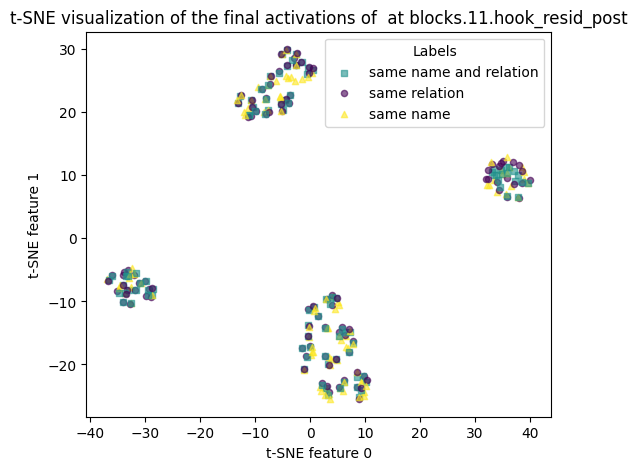

In [ ]:
activation_plot_final_acts_optimised(
  model = gpt2_small,
  datasets_lang = family_datasets,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.11.hook_resid_post',
  dimension = 2
)

# Final Plots

In [12]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

In [13]:
import re

def extract_first_integer(s):
    # Use a regular expression to match any sequence of digits in the string
    matches = re.findall(r'\d+', s)

    # If matches are found, return the first one as an integer
    if matches:
        if s[-4:] == "post":
          return int(matches[0]) + 1
        else:
          return int(matches[0])
    return None

In [14]:
def activation_plot_final_acts_optimised_final(
  model: HookedTransformer,
  datasets_lang: List[str],
  datasets_tokens: List,
  plot_type: str,
  location: str,
  dimension: int,
  random: bool = False,
  centre: bool = True
):
  """
  Given a dataset, create a plot of the activations for the final token.
  Use gpt 2 small, look at any given location.
  Works for either numerical or categorical labels.
  Should support both t-SNE and PCA.
  """
  t.cuda.empty_cache()
  activation_dict = {}
  # Do the forward pass for each dataset
  for name in datasets_lang:
    dataset_lang = datasets_lang[name]
    final_activations = dataset_activations_optimised(model, dataset_lang, location, 16)
    # Looking at the final activations! Might want to change this?

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  for name in datasets_tokens:
    dataset_token = datasets_tokens[name]
    activations = dataset_activations_tokens(model, dataset_token)[1][location]
    # Looking at the final activations! Might want to change this?
    final_activations = activations[:,-1,:]

    # target_X = reshape_activations(activations)

    # Convert the tensor to a numpy array as scikit-learn works with numpy arrays
    data_numpy = final_activations.cpu().numpy()
    activation_dict[name] = data_numpy

  all_data = []
  all_labels = []
  for label, data in activation_dict.items():
      all_data.append(data)
      all_labels.extend([label] * len(data))

  all_data = np.concatenate(all_data, axis=0)


  if random:

    # Determine the number of data points per label (assuming all labels have the same number of data points)
    num_points_per_label = len(activation_dict[list(activation_dict.keys())[0]])

    # Calculate the mean and variance of the entire dataset
    mean = np.mean(all_data, axis=0)
    variance = np.var(all_data, axis=0)
    # Generate some random data
    # Will use the same mean and variance as the data
    # Generate synthetic data with the same variance
    if centre:
      synthetic_data = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    else:
      zeros = 0 * mean
      synthetic_data = np.random.normal(loc=zeros, scale=np.sqrt(variance), size=(num_points_per_label, all_data.shape[1]))
    synthetic_labels = ['Synthetic'] * len(synthetic_data)

    # Concatenate the synthetic data with the original data
    all_data = np.concatenate([all_data, synthetic_data], axis=0)
    all_labels.extend(synthetic_labels)



  # Initialize the t-SNE
  tsne = TSNE(n_components=2, random_state=21)

  # Fit and transform the data to 2D
  data_2d = tsne.fit_transform(all_data)

  data_2d_copy, all_labels_copy = data_2d, all_labels


  # Shuffle the data and labels
  data_2d, all_labels = shuffle(data_2d, all_labels, random_state=42)

  # Plot the transformed data
  # Create a colormap for labels
  unique_labels = list(set(all_labels))
  colors = plt.cm.get_cmap('viridis', len(unique_labels))

  # Plot the transformed data with labels
  plt.figure(figsize=(6, 5))
  markers = ['o', 's', '^', 'D', 'P']

  all_possible_dataset_names = sorted(list(set(datasets_lang)))

  # Step 2: Markers and Colors Mapping
  colors_map = plt.cm.get_cmap('viridis', len(all_possible_dataset_names))
  markers_map = ['o', 's', '^', 'D', 'P']

  # Create a dict to map dataset name to a color and marker
  label_to_color_marker = {
      dataset_name: (colors_map(idx), markers_map[idx % len(markers_map)])
      for idx, dataset_name in enumerate(all_possible_dataset_names)
  }

  plotted_labels = set()  # To track which labels have been plotted to avoid redundant legend entries
  for i, label in enumerate(all_labels):
      color, marker = label_to_color_marker[label]
      legend_label = label if label not in plotted_labels else ""
      plt.scatter(data_2d[i, 0], data_2d[i, 1], color=color, s=20, alpha=0.6, label=legend_label, marker=marker)
      plotted_labels.add(label)

  # Add a legend
  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend(handles, labels, title="Labels", fontsize=16)

  plt.xlabel('t-SNE feature 0', fontsize=16)
  plt.ylabel('t-SNE feature 1', fontsize=16)
  layer_number = extract_first_integer(location)
  plt.title(f'Layer Index = {layer_number}', fontsize=16)
  from datetime import datetime
  # Get the current date and time
  now = datetime.now()

  # Get the current time
  current_time = now.time()
  plt.savefig(f"tsne-{now}.pdf", format='pdf')
  plt.show()
  return data_2d_copy, all_labels_copy

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



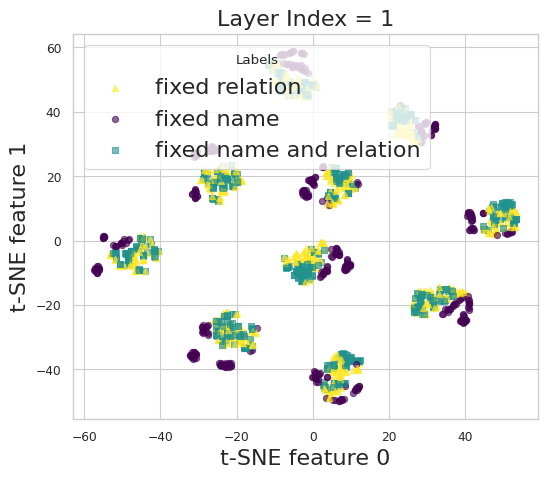

In [17]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.0.hook_resid_post',
  dimension = 2
)

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



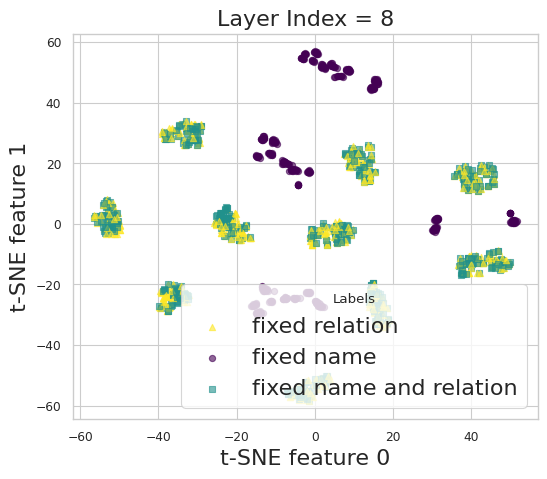

In [18]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.7.hook_resid_post',
  dimension = 2
)

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



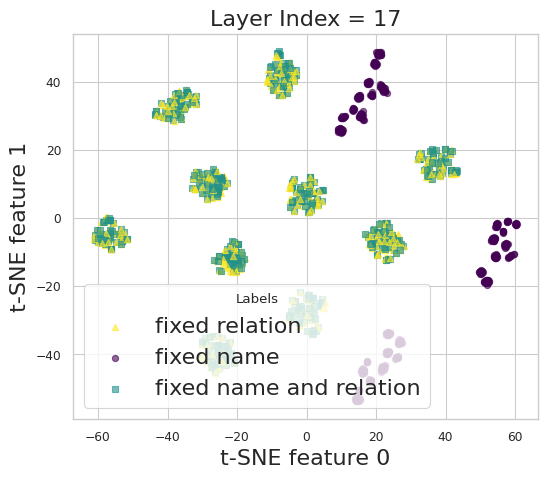

In [19]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.16.hook_resid_post',
  dimension = 2
)

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



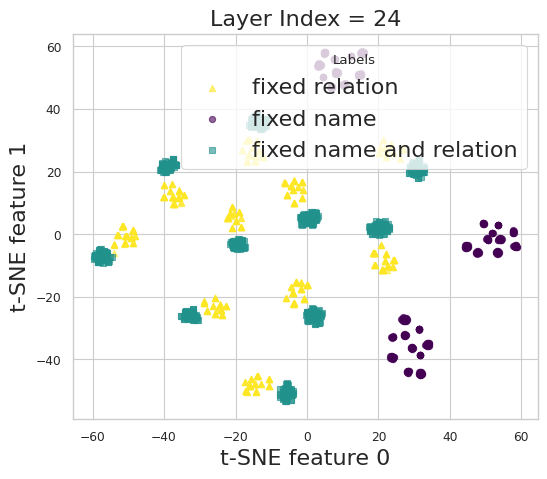

In [20]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.23.hook_resid_post',
  dimension = 2
)

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



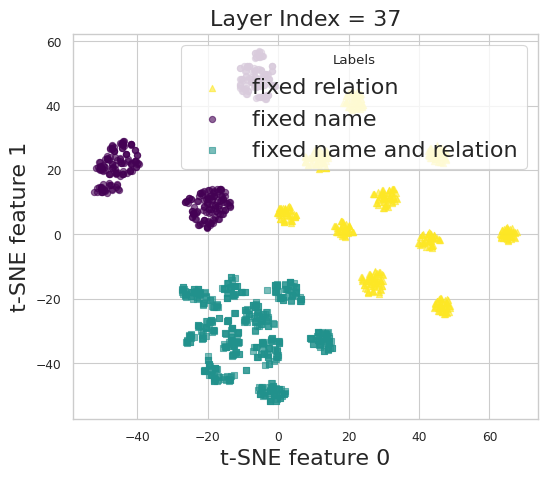

In [21]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.36.hook_resid_post',
  dimension = 2
)

<ipython-input-14-87a5d153bb12>:91: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-14-87a5d153bb12>:100: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



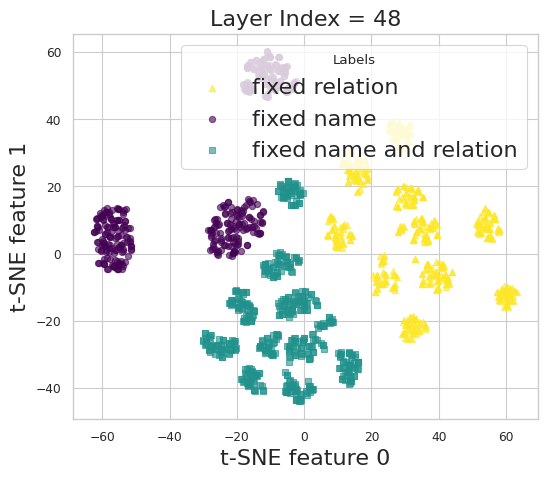

In [22]:
tsne_data, labels = activation_plot_final_acts_optimised_final(
  model = gpt2_xl,
  datasets_lang = family_datasets_updated,
  datasets_tokens = {},
  plot_type = None,
  location ='blocks.47.hook_resid_post',
  dimension = 2
)